# Imports

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import time
from contextlib import contextmanager
import gc
import warnings
import pprint
from IPython.display import clear_output

# Configuration

In [154]:
DEBUG = True
DF_MAIN = None
TEST_SIZE = 1/4
SAMPLE_ROWS = 10000
RANDOM_STATE= 190276
ROOT_INPUT = './data/original/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()

# Fonctions

In [155]:
# Time tracking
@contextmanager
def timer(title: str):
    t0 = time.time()
    yield
    print("{} - éxécuté en {:.0f}s".format(title, time.time() - t0))

# Read and Sample CSV
def read(name: str, index: str = None, dates: [str] = []) -> pd.DataFrame:
    path = ROOT_INPUT + name
    print(f"Read file {path}")
    df = pd.read_csv(ROOT_INPUT + name, index_col=index, parse_dates= dates)
    print(f'{name} shape: {df.shape}')
    return df

# Affichage des infos du dataset
def infos(df: pd.DataFrame, head = False):
    memory_gb = np.round(df.memory_usage(deep=True).sum()/(1024**3),2)
    nb_lignes = df.shape[0]
    nb_columns = df.shape[1]
    print(f'A ce stade ce dataset contient {nb_lignes} lignes et {nb_columns} colonnes. (conso mémoire {memory_gb}Gb)')
    if head:
        return df.head()
    
# Graphe des taux de remplissage
def remplissage(df: pd.DataFrame, treshold: int = 101, ascending: bool = False):
    df_na = pd.DataFrame(((1- df.isna().mean()) * 100).round(0)).rename(columns={0: 'mean'})
    df_na = df_na[df_na['mean'] < treshold]
    ax = sns.barplot(data=df_na, x='mean', y=df_na.index, palette='rainbow', order=df_na.sort_values(by='mean', ascending=ascending).index)
    ax.bar_label(ax.containers[0], fmt='%.0f%%', padding=-35, c="white")
    plt.title(f'Taux de remplissage inférieur à {treshold} : {df_na.size} colonnes')
    plt.show()
    
def split(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train, df_test = model_selection.train_test_split(df, test_size=TEST_SIZE, random_state= RANDOM_STATE)
    return df_train, df_test

def scale(df: pd.DataFrame) -> pd.DataFrame:
    scaler = preprocessing.StandardScaler()
    columns = df.columns
    index = df.index
    df_scaled = scaler.fit_transform(df)
    
    df_scaled = pd.DataFrame(df_scaled, columns=columns, index=index)
    
    return df_scaled

def one_hot_encode(df: pd.DataFrame) -> tuple[pd.DataFrame, [str]]:
    print(f"shape before encode: {df.shape}")    
    
    previous_columns = df.columns.to_list()
    df = pd.get_dummies(df)
    after_columns = df.columns.to_list()
    cols = [col for index, col in enumerate(after_columns) if col not in previous_columns]
        
    print(f"shape after encode: {df.shape}")
       
    return df, cols

# Load DataFrames

In [156]:
df_infos = [
    {'file': 'olist_customers_dataset.csv', 'index': 'customer_id', 'name': 'customers', 'dates': []},
    {'file': 'olist_geolocation_dataset.csv', 'index': 'geolocation_zip_code_prefix', 'name': 'geolocation', 'dates': []},
    {'file': 'olist_order_items_dataset.csv', 'index': 'order_id', 'name': 'order_items', 'dates': ['shipping_limit_date']},
    {'file': 'olist_order_payments_dataset.csv', 'index': 'order_id', 'name': 'order_payments', 'dates': []},
    {'file': 'olist_order_reviews_dataset.csv', 'index': 'review_id', 'name': 'order_reviews', 'dates': ['review_creation_date', 'review_answer_timestamp']},
    {'file': 'olist_orders_dataset.csv', 'index': 'order_id', 'name': 'orders', 'dates': ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']},
    {'file': 'olist_products_dataset.csv', 'index': 'product_id', 'name': 'products', 'dates': []},
    {'file': 'olist_sellers_dataset.csv', 'index': 'seller_id', 'name': 'sellers', 'dates': []},
    {'file': 'product_category_name_translation.csv', 'index': 'product_category_name', 'name': 'product_category_name_translation', 'dates': []}
]

dfs: dict[str, pd.DataFrame] = {}

for info in df_infos:
    dfs[info['name']] = read(name=info['file'], index=info['index'], dates=info['dates'])
    print("")


# Copy originals dataFrames
df_customers = dfs['customers'].copy()
df_geolocation = dfs['geolocation'].copy()
df_order_items = dfs['order_items'].copy()
df_order_payments = dfs['order_payments'].copy()
df_order_reviews = dfs['order_reviews'].copy()
df_orders = dfs['orders'].copy()
df_products = dfs['products'].copy()
df_sellers = dfs['sellers'].copy()
df_product_category_name_translation = dfs['product_category_name_translation']


print('Les dataframes suivants sont chargés:')
pprint.pprint(list(dfs.keys()))

Read file ./data/original/olist_customers_dataset.csv
olist_customers_dataset.csv shape: (99441, 4)

Read file ./data/original/olist_geolocation_dataset.csv
olist_geolocation_dataset.csv shape: (1000163, 4)

Read file ./data/original/olist_order_items_dataset.csv
olist_order_items_dataset.csv shape: (112650, 6)

Read file ./data/original/olist_order_payments_dataset.csv
olist_order_payments_dataset.csv shape: (103886, 4)

Read file ./data/original/olist_order_reviews_dataset.csv
olist_order_reviews_dataset.csv shape: (99224, 6)

Read file ./data/original/olist_orders_dataset.csv
olist_orders_dataset.csv shape: (99441, 7)

Read file ./data/original/olist_products_dataset.csv
olist_products_dataset.csv shape: (32951, 8)

Read file ./data/original/olist_sellers_dataset.csv
olist_sellers_dataset.csv shape: (3095, 3)

Read file ./data/original/product_category_name_translation.csv
product_category_name_translation.csv shape: (71, 1)

Les dataframes suivants sont chargés:
['customers',
 'geo

# Aggregate DataFrames

## Aggregation de Geolocation dans Sellers et Customers

In [157]:
df_geolocation.head()

,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
geolocation_zip_code_prefix,,,,
1037,-23.545621,-46.639292,sao paulo,SP
1046,-23.546081,-46.644820,sao paulo,SP
1046,-23.546129,-46.642951,sao paulo,SP
1041,-23.544392,-46.639499,sao paulo,SP
1035,-23.541578,-46.641607,sao paulo,SP


In [158]:
df_geolocation.index.has_duplicates

True

Les zip codes apparaissent plusieurs fois avec des données GPS différentes => Groupement par Zip code avec median des Longitude/Latitude avant aggrégation à Customers et Sellers

In [159]:
df_geolocation = df_geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'median', 'geolocation_lng': 'median'})
df_geolocation.head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
1001,-23.550381,-46.634027
1002,-23.548551,-46.635072
1003,-23.548977,-46.635313
1004,-23.549535,-46.634771
1005,-23.549612,-46.636532


Ajout de Geolocation à Customers et Sellers. 

In [160]:
df_customers = df_customers.join(df_geolocation, on='customer_zip_code_prefix')
df_customers.rename(columns={'geolocation_lat': 'customer_geolocation_lat'}, inplace=True)
df_customers.rename(columns={'geolocation_lng': 'customer_geolocation_lng'}, inplace=True)

df_sellers = df_sellers.join(df_geolocation, on='seller_zip_code_prefix')
df_sellers.rename(columns={'geolocation_lat': 'seller_geolocation_lat'}, inplace=True)
df_sellers.rename(columns={'geolocation_lng': 'seller_geolocation_lng'}, inplace=True)

## Aggrégation de Customers, Order_reviews, Order_payments dans Orders

### Traitement Customers

In [161]:
df_customers.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng
customer_id,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.502070,-47.396822
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727299,-46.542631
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531294,-46.656404
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.497390,-46.182342
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.973309,-47.141530


In [162]:
df_customers.index.has_duplicates

False

Pas de traitement nécéssaire avant aggrégation dans Orders

### Traitement Order_payments

In [163]:
df_order_payments.head()

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [164]:
df_order_payments.index.has_duplicates

True

Traitement nécéssaire pour aggreger Order_payments dans Orders:
1. Encoder payment_type
2. Grouper par order_id

In [165]:
df_order_payments = pd.get_dummies(df_order_payments, columns=['payment_type'])

In [166]:
df_order_payments

,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
order_id,,,,,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,8,99.33,False,True,False,False,False
a9810da82917af2d9aefd1278f1dcfa0,1,1,24.39,False,True,False,False,False
25e8ea4e93396b6fa0d3dd708e76c1bd,1,1,65.71,False,True,False,False,False
ba78997921bbcdc1373bb41e913ab953,1,8,107.78,False,True,False,False,False
42fdf880ba16b47b59251dd489d4441a,1,2,128.45,False,True,False,False,False
...,...,...,...,...,...,...,...,...
0406037ad97740d563a178ecc7a2075c,1,1,363.31,True,False,False,False,False
7b905861d7c825891d6347454ea7863f,1,2,96.80,False,True,False,False,False
32609bbb3dd69b3c066a6860554a77bf,1,1,47.77,False,True,False,False,False


In [167]:
agg = {
    'payment_sequential': 'max',
    'payment_installments': 'max',
    'payment_value': 'sum',
    'payment_type_boleto': 'max',
    'payment_type_credit_card': 'max',
    'payment_type_debit_card': 'max',
    'payment_type_not_defined': 'max',
    'payment_type_voucher': 'max'
}
df_order_payments = df_order_payments.groupby('order_id').agg(agg)

In [168]:
df_order_payments

,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
order_id,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19,False,True,False,False,False
00018f77f2f0320c557190d7a144bdd3,1,3,259.83,False,True,False,False,False
000229ec398224ef6ca0657da4fc703e,1,5,216.87,False,True,False,False,False
00024acbcdf0a6daa1e931b038114c75,1,2,25.78,False,True,False,False,False
00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04,False,True,False,False,False
...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,1,343.40,True,False,False,False,False
fffcd46ef2263f404302a634eb57f7eb,1,1,386.53,True,False,False,False,False
fffce4705a9662cd70adb13d4a31832d,1,3,116.85,False,True,False,False,False


### Traitement Order_reviews

In [169]:
df_order_reviews.head()

,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
review_id,,,,,,
7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [170]:
df_order_reviews['order_id'].duplicated().value_counts()

order_id
False    98673
True       551
Name: count, dtype: int64

Traitement nécéssaire pour aggreger Order_reviews dans Orders:
1. Supprimer les comment title et message
2. Grouper par order_id

In [171]:
agg = {
    'review_score': 'mean',
    'review_creation_date': 'mean',
    'review_answer_timestamp': 'mean'
}
df_order_reviews = df_order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])
df_order_reviews = df_order_reviews.groupby('order_id').agg(agg)
df_order_reviews

,review_score,review_creation_date,review_answer_timestamp
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,5.0,2017-09-21,2017-09-22 10:57:03
00018f77f2f0320c557190d7a144bdd3,4.0,2017-05-13,2017-05-15 11:34:13
000229ec398224ef6ca0657da4fc703e,5.0,2018-01-23,2018-01-23 16:06:31
00024acbcdf0a6daa1e931b038114c75,4.0,2018-08-15,2018-08-15 16:39:01
00042b26cf59d7ce69dfabb4e55b4fd9,5.0,2017-03-02,2017-03-03 10:54:59
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,5.0,2018-05-11,2018-05-14 12:53:47
fffcd46ef2263f404302a634eb57f7eb,5.0,2018-07-24,2018-07-25 09:25:29
fffce4705a9662cd70adb13d4a31832d,5.0,2017-10-29,2017-10-29 21:33:52


### Aggregation

In [172]:
df_orders = df_orders.join(df_customers, on='customer_id', how='left')
df_orders = df_orders.join(df_order_payments, on='order_id', how='left')
df_orders = df_orders.join(df_order_reviews, on='order_id', how='left')
df_orders

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score,review_creation_date,review_answer_timestamp
order_id,,,,,,,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576170,-46.587276,3.0,1.0,38.71,False,True,False,False,True,4.0,2017-10-11,2017-10-12 03:43:48
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.126651,-45.008162,1.0,1.0,141.46,True,False,False,False,False,4.0,2018-08-08,2018-08-08 18:37:50
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.744472,-48.514624,1.0,3.0,179.12,False,True,False,False,False,5.0,2018-08-18,2018-08-22 19:07:58
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,-5.774611,-35.273916,1.0,1.0,72.20,False,True,False,False,False,5.0,2017-12-03,2017-12-05 19:21:58
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,-23.675316,-46.515116,1.0,1.0,28.62,False,True,False,False,False,5.0,2018-02-17,2018-02-18 13:02:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,-23.177440,-45.885721,1.0,3.0,85.08,False,True,False,False,False,5.0,2017-03-22,2017-03-23 11:02:08
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,-24.001611,-46.449189,1.0,3.0,195.00,False,True,False,False,False,4.0,2018-03-01,2018-03-02 17:50:01
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,-17.897354,-39.372113,1.0,5.0,271.01,False,True,False,False,False,5.0,2017-09-22,2017-09-22 23:10:57


## Aggrégation de Orders, Products, Sellers dans Orders_items

### Traitement Sellers

In [173]:
df_sellers.head()

,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng
seller_id,,,,,
3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.894561,-47.062380
d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.382440,-46.947605
ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.909624,-43.176774
c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,-23.657453,-46.612406
51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.964436,-46.535090


In [174]:
df_sellers.index.has_duplicates

False

Pas de traitement nécéssaire de Sellers avant aggrégation dans Order_items

### Traitement Products

In [175]:
df_products.head()

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [176]:
df_products.index.has_duplicates

False

Pas de traitement nécéssaire de Products avant aggrégation dans Order_items

### Traitement de Orders

In [177]:
df_orders.head()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score,review_creation_date,review_answer_timestamp
order_id,,,,,,,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.576170,-46.587276,3.0,1.0,38.71,False,True,False,False,True,4.0,2017-10-11,2017-10-12 03:43:48
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.126651,-45.008162,1.0,1.0,141.46,True,False,False,False,False,4.0,2018-08-08,2018-08-08 18:37:50
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.744472,-48.514624,1.0,3.0,179.12,False,True,False,False,False,5.0,2018-08-18,2018-08-22 19:07:58
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,-5.774611,-35.273916,1.0,1.0,72.20,False,True,False,False,False,5.0,2017-12-03,2017-12-05 19:21:58
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,-23.675316,-46.515116,1.0,1.0,28.62,False,True,False,False,False,5.0,2018-02-17,2018-02-18 13:02:51


In [178]:
df_orders.index.has_duplicates

False

Pas de traitement nécéssaire de Orders avant aggrégation dans Order_items

### Aggregation

In [179]:
df_order_items = df_order_items.join(df_orders, on='order_id', how='left')
df_order_items = df_order_items.join(df_sellers, on='seller_id', how='left')
df_order_items = df_order_items.join(df_products, on='product_id', how='left')

df_order_items

,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,payment_sequential,payment_installments,payment_value,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,review_score,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.762829,-41.310605,1.0,2.0,72.19,False,True,False,False,False,5.0,2017-09-21,2017-09-22 10:57:03,27277,volta redonda,SP,-22.498419,-44.125272,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.205737,-50.926924,1.0,3.0,259.83,False,True,False,False,False,4.0,2017-05-13,2017-05-15 11:34:13,3471,sao paulo,SP,-23.564289,-46.519045,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.870383,-44.594355,1.0,5.0,216.87,False,True,False,False,False,5.0,2018-01-23,2018-01-23 16:06:31,37564,borda da mata,MG,-22.271648,-46.165556,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.104346,-46.595589,1.0,2.0,25.78,False,True,False,False,False,4.0,2018-08-15,2018-08-15 16:39:01,14403,franca,SP,-20.554951,-47.387691,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.245512,-46.825182,1.0,3.0,218.04,False,True,False,False,False,5.0,2017-03-02,2017-03-03 10:54:59,87900,loanda,PR,-22.930408,-53.136438,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,-2.493458,-44.302009,1.0,1.0,343.40

# Exploration

In [180]:
DF_MAIN = df_order_items.copy()

## Types des colonnes

In [181]:
DF_MAIN.dtypes

order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
customer_geolocation_lat                float64
customer_geolocation_lng                float64
payment_sequential                      float64
payment_installments                    

In [182]:
DF_MAIN.dtypes[DF_MAIN.dtypes == 'object']

product_id                  object
seller_id                   object
customer_id                 object
order_status                object
customer_unique_id          object
customer_city               object
customer_state              object
payment_type_boleto         object
payment_type_credit_card    object
payment_type_debit_card     object
payment_type_not_defined    object
payment_type_voucher        object
seller_city                 object
seller_state                object
product_category_name       object
dtype: object

In [183]:
DF_MAIN.drop(columns=['product_id', 'seller_id', 'customer_id', 'customer_unique_id'], inplace=True)

In [184]:
DF_MAIN.dtypes[DF_MAIN.dtypes == 'object']

order_status                object
customer_city               object
customer_state              object
payment_type_boleto         object
payment_type_credit_card    object
payment_type_debit_card     object
payment_type_not_defined    object
payment_type_voucher        object
seller_city                 object
seller_state                object
product_category_name       object
dtype: object

In [185]:
for cat in DF_MAIN.dtypes[DF_MAIN.dtypes == 'object'].index:
    print(f'{cat:.<30}: {len(DF_MAIN[cat].unique()):>4} valeurs uniques')

order_status..................:    7 valeurs uniques
customer_city.................: 4110 valeurs uniques
customer_state................:   27 valeurs uniques
payment_type_boleto...........:    3 valeurs uniques
payment_type_credit_card......:    3 valeurs uniques
payment_type_debit_card.......:    3 valeurs uniques
payment_type_not_defined......:    2 valeurs uniques
payment_type_voucher..........:    3 valeurs uniques
seller_city...................:  611 valeurs uniques
seller_state..................:   23 valeurs uniques
product_category_name.........:   74 valeurs uniques


## Enregistrements incomplets

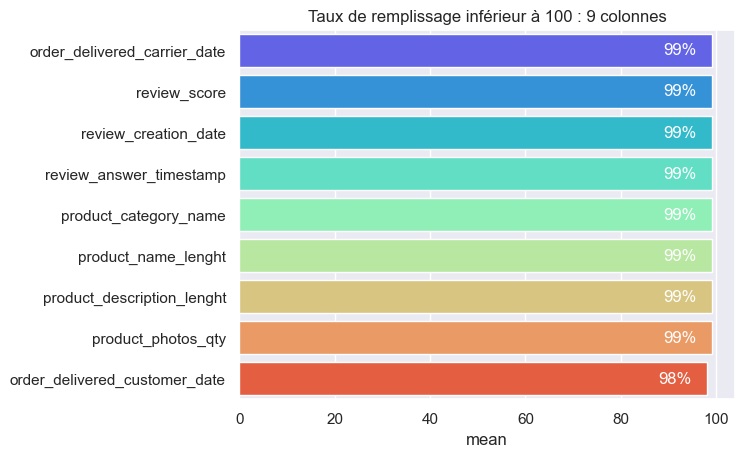

In [186]:
remplissage(DF_MAIN, 100)

In [187]:
DF_MAIN.shape

(112650, 39)

In [188]:
DF_MAIN.dropna().shape

(107296, 39)

On ne perd que 4,7% du dataset en supprimant les enregitrement incomplets

In [189]:
DF_MAIN.dropna(inplace=True)

In [190]:
pd.set_option('display.max_columns', 45)
DF_MAIN.describe()

,order_item_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_geolocation_lat,customer_geolocation_lng,payment_sequential,payment_installments,payment_value,review_score,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,107296.000000,107296,107296.000000,107296.000000,107296,107296,107296,107296,107296,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296,107296,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000,107296.000000
mean,1.196261,2018-01-09 16:32:42.565155840,119.995335,19.970872,2018-01-03 02:04:36.664097280,2018-01-03 12:36:18.937378816,2018-01-06 08:36:40.765098496,2018-01-15 12:02:32.878280704,2018-01-26 21:14:02.290486272,35075.282331,-21.252244,-46.220075,1.044568,3.016506,179.248866,4.083793,2018-01-15 07:11:03.323889152,2018-01-18 10:43:27.720795904,24541.839351,-22.796872,-47.249325,48.797159,787.342557,2.205888,2092.036367,30.179233,16.600423,23.015797
min,1.000000,2016-10-08 10:34:01,0.850000,0.000000,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1003.000000,-33.690972,-72.670987,1.000000,0.000000,9.590000,1.000000,2016-10-15 00:00:00,2016-10-16 03:20:17,1001.000000,-32.074657,-63.893145,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,1.000000,2017-09-22 04:52:26.750000128,39.900000,13.070000,2017-09-16 12:02:20,2017-09-16 17:44:27,2017-09-19 18:32:59,2017-09-27 19:36:41.249999872,2017-10-09 00:00:00,11095.000000,-23.592563,-48.125200,1.000000,1.000000,65.540000,4.000000,2017-09-28 00:00:00,2017-10-01 13:57:55,6429.000000,-23.610280,-48.829768,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,1.000000,2018-01-29 18:16:30.500000,74.900000,16.280000,2018-01-22 15:38:53.500000,2018-01-23 02:45:21,2018-01-25 18:07:52,2018-02-05 17:28:07.500000,2018-02-19 00:00:00,24240.000000,-22.930358,-46.635686,1.000000,2.000000,113.970000,5.000000,2018-02-06 00:00:00,2018-02-07 21:23:16,13660.000000,-23.424399,-46.755492,52.000000,602.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,1.000000,2018-05-11 17:30:44.249999872,134.900000,21.150000,2018-05-07 00:48:49.500000,2018-05-07 18:09:48,2018-05-09 12:12:00,2018-05-16 18:30:37.750000128,2018-05-29 00:00:00,58757.500000,-20.196781,-43.688277,1.000000,4.000000,195.120000,5.000000,2018-05-17 00:00:00,2018-05-20 21:26:10.500000,28035.000000,-21.757690,-46.522148,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99980.000000,42.184003,-8.577855,26.000000,24.000000,13664.080000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,99730.000000,-2.498944,-34.855123,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000
std,0.693059,NaN,180.984757,15.737058,NaN,NaN,NaN,NaN,NaN,29897.883711,5.557576,4.036508,0.377311,2.802730,270.242426,1.344163,NaN,NaN,27688.645522,2.709162,2.346186,10.011548,651.766456,1.717308,3735.996843,16.135318,13.440185,11.667469


<Axes: >

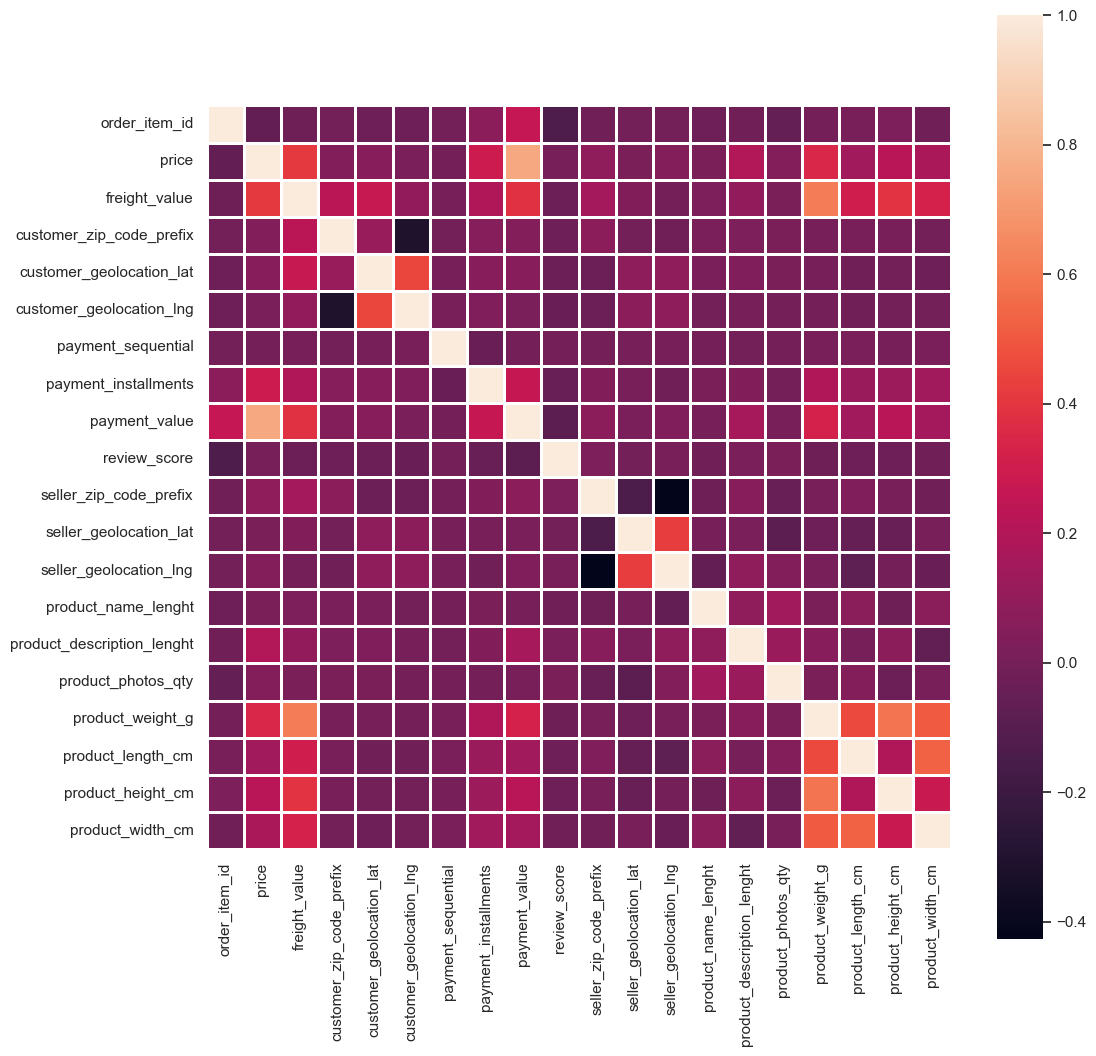

In [191]:
fig = plt.figure(figsize=(12,12))
corr = DF_MAIN.corr(numeric_only=True)
sns.heatmap(corr, linewidths=1, square=True)

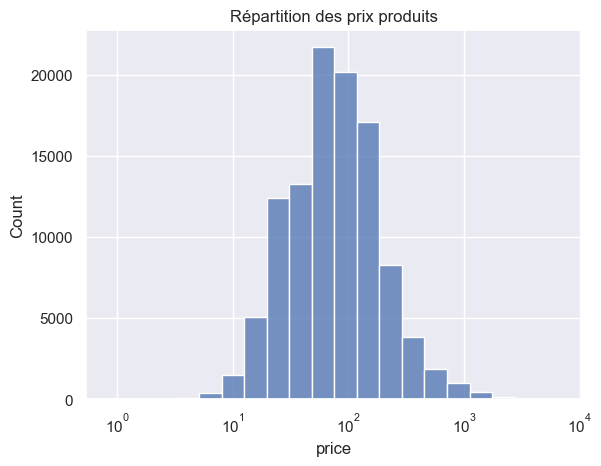

In [192]:
ax = sns.histplot(data=DF_MAIN, x='price', bins=20, log_scale=True)
ax.set(title='Répartition des prix produits')
plt.show()

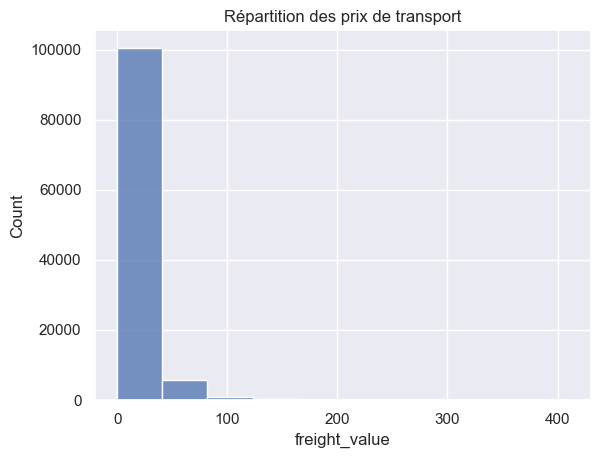

In [193]:
ax = sns.histplot(data=DF_MAIN, x='freight_value', bins=10)
ax.set(title='Répartition des prix de transport')
plt.show()

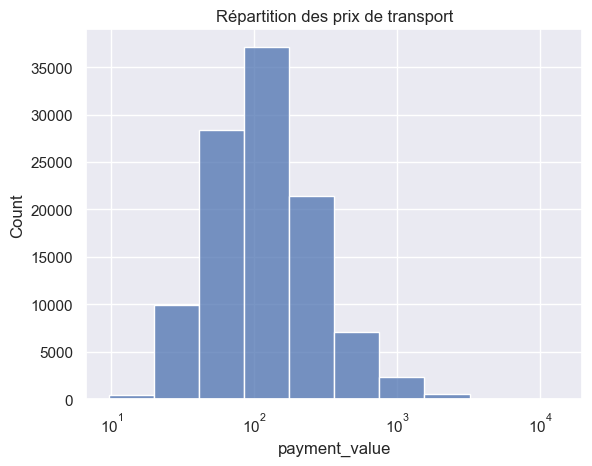

In [194]:
ax = sns.histplot(data=DF_MAIN, x='payment_value', bins=10, log_scale=True)
ax.set(title='Répartition des prix de transport')
plt.show()

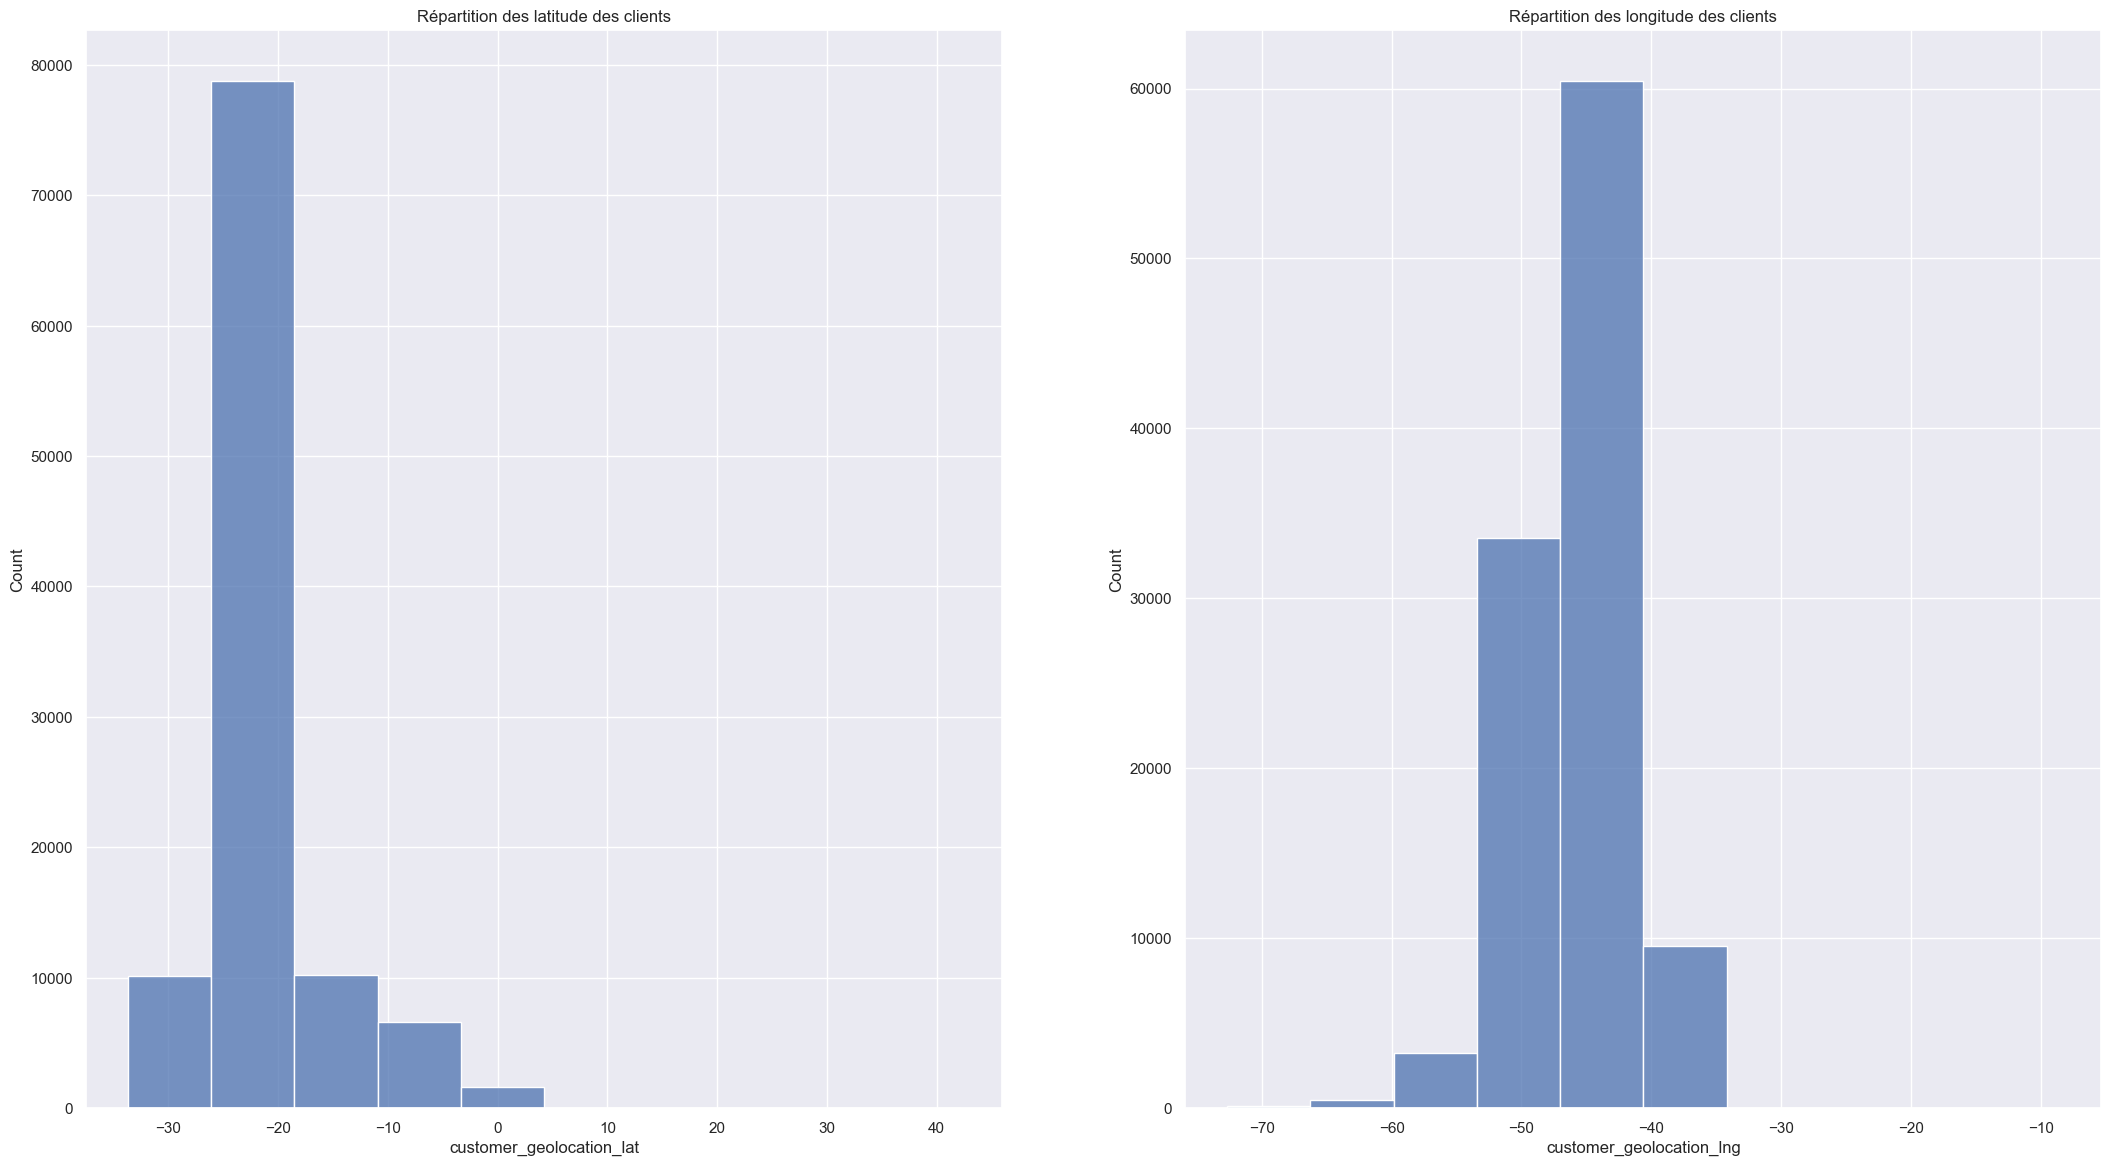

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))
ax1 = sns.histplot(data=DF_MAIN, x='customer_geolocation_lat', bins=10, ax=ax1)
ax1.set(title='Répartition des latitude des clients')
ax2 = sns.histplot(data=DF_MAIN, x='customer_geolocation_lng', bins=10, ax=ax2)
ax2.set(title='Répartition des longitude des clients')
plt.show()

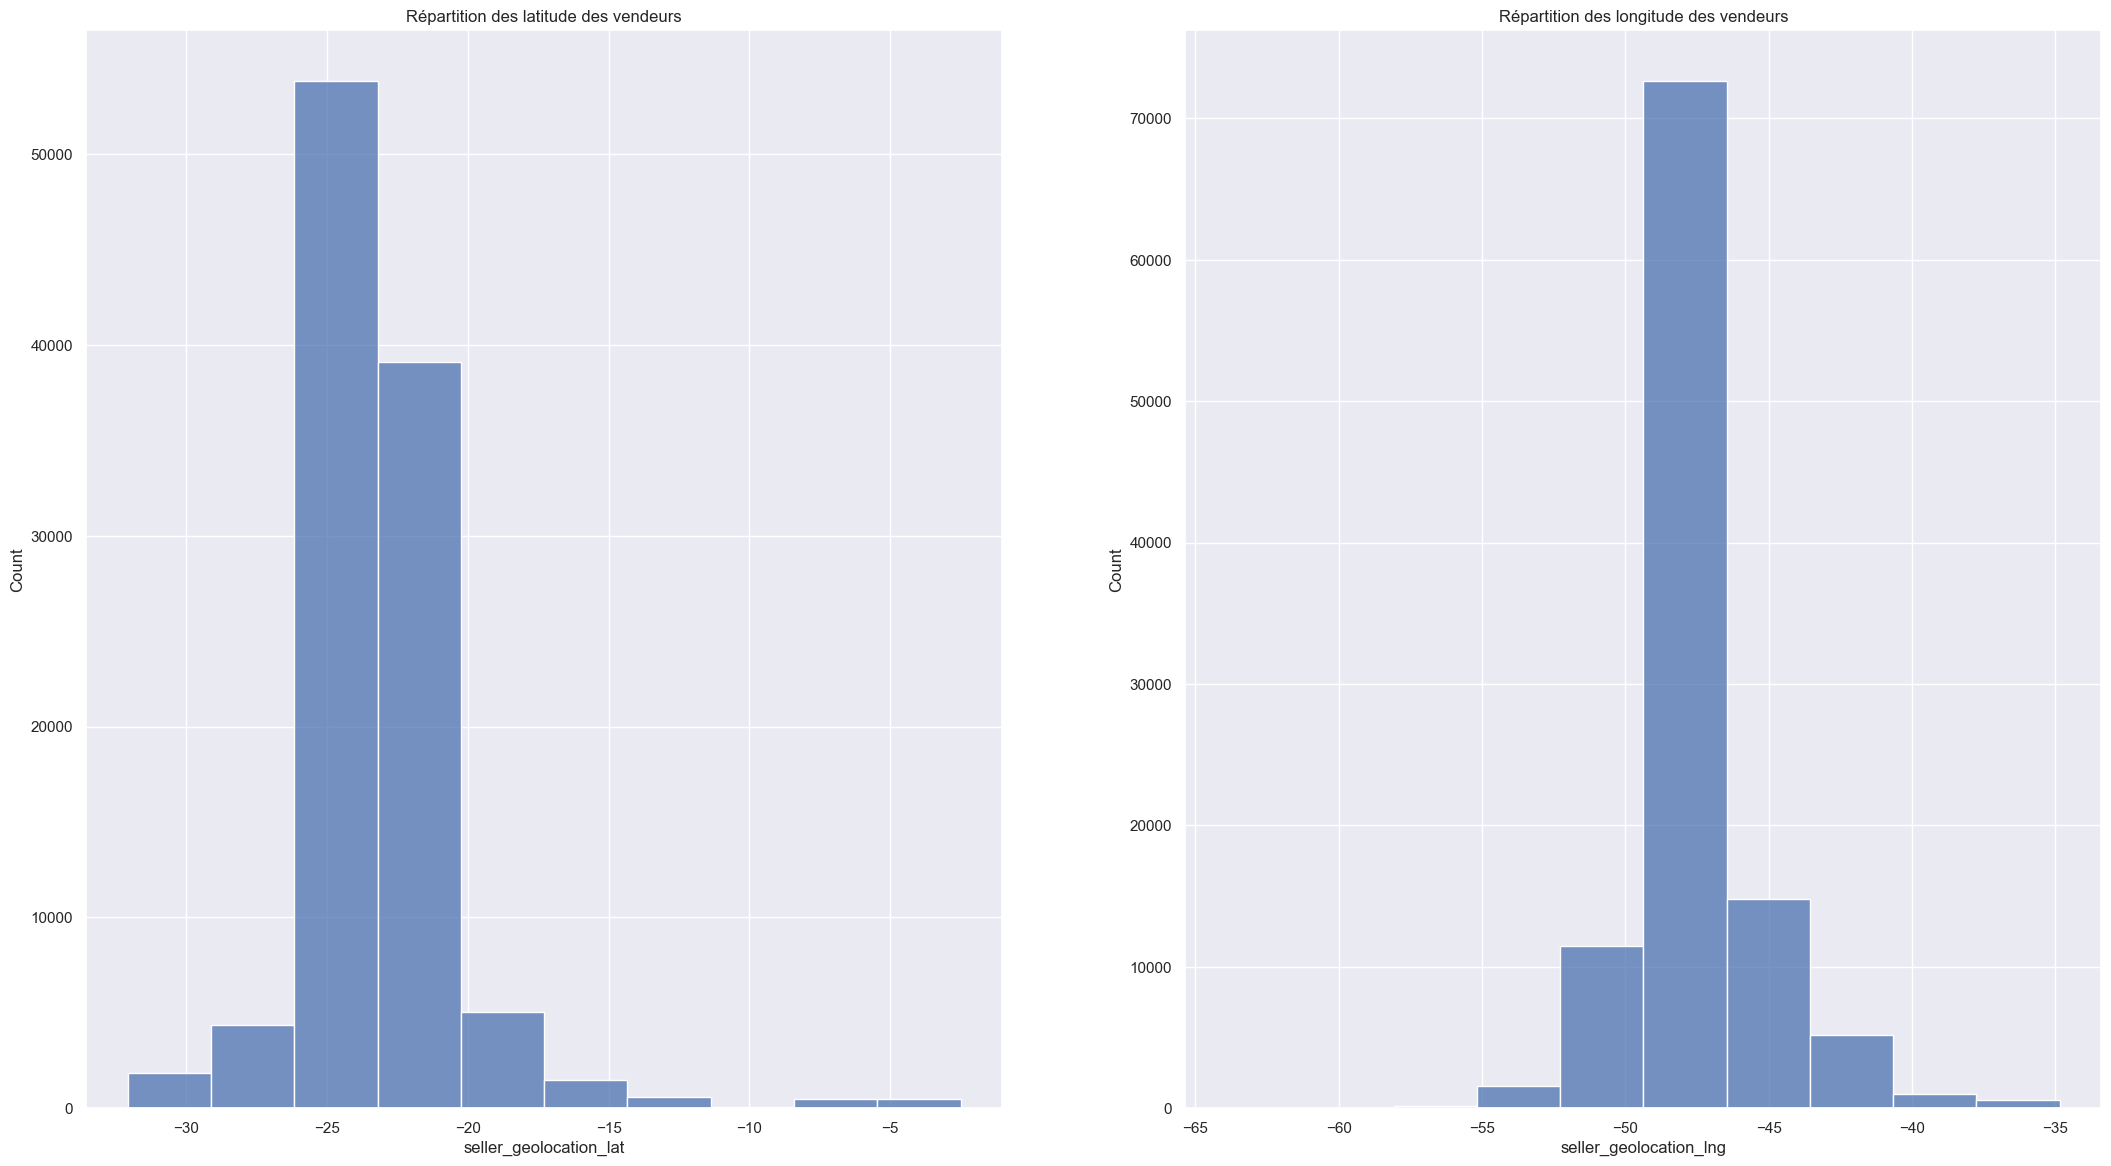

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14))
ax1 = sns.histplot(data=DF_MAIN, x='seller_geolocation_lat', bins=10, ax=ax1)
ax1.set(title='Répartition des latitude des vendeurs')
ax2 = sns.histplot(data=DF_MAIN, x='seller_geolocation_lng', bins=10, ax=ax2)
ax2.set(title='Répartition des longitude des vendeurs')
plt.show()

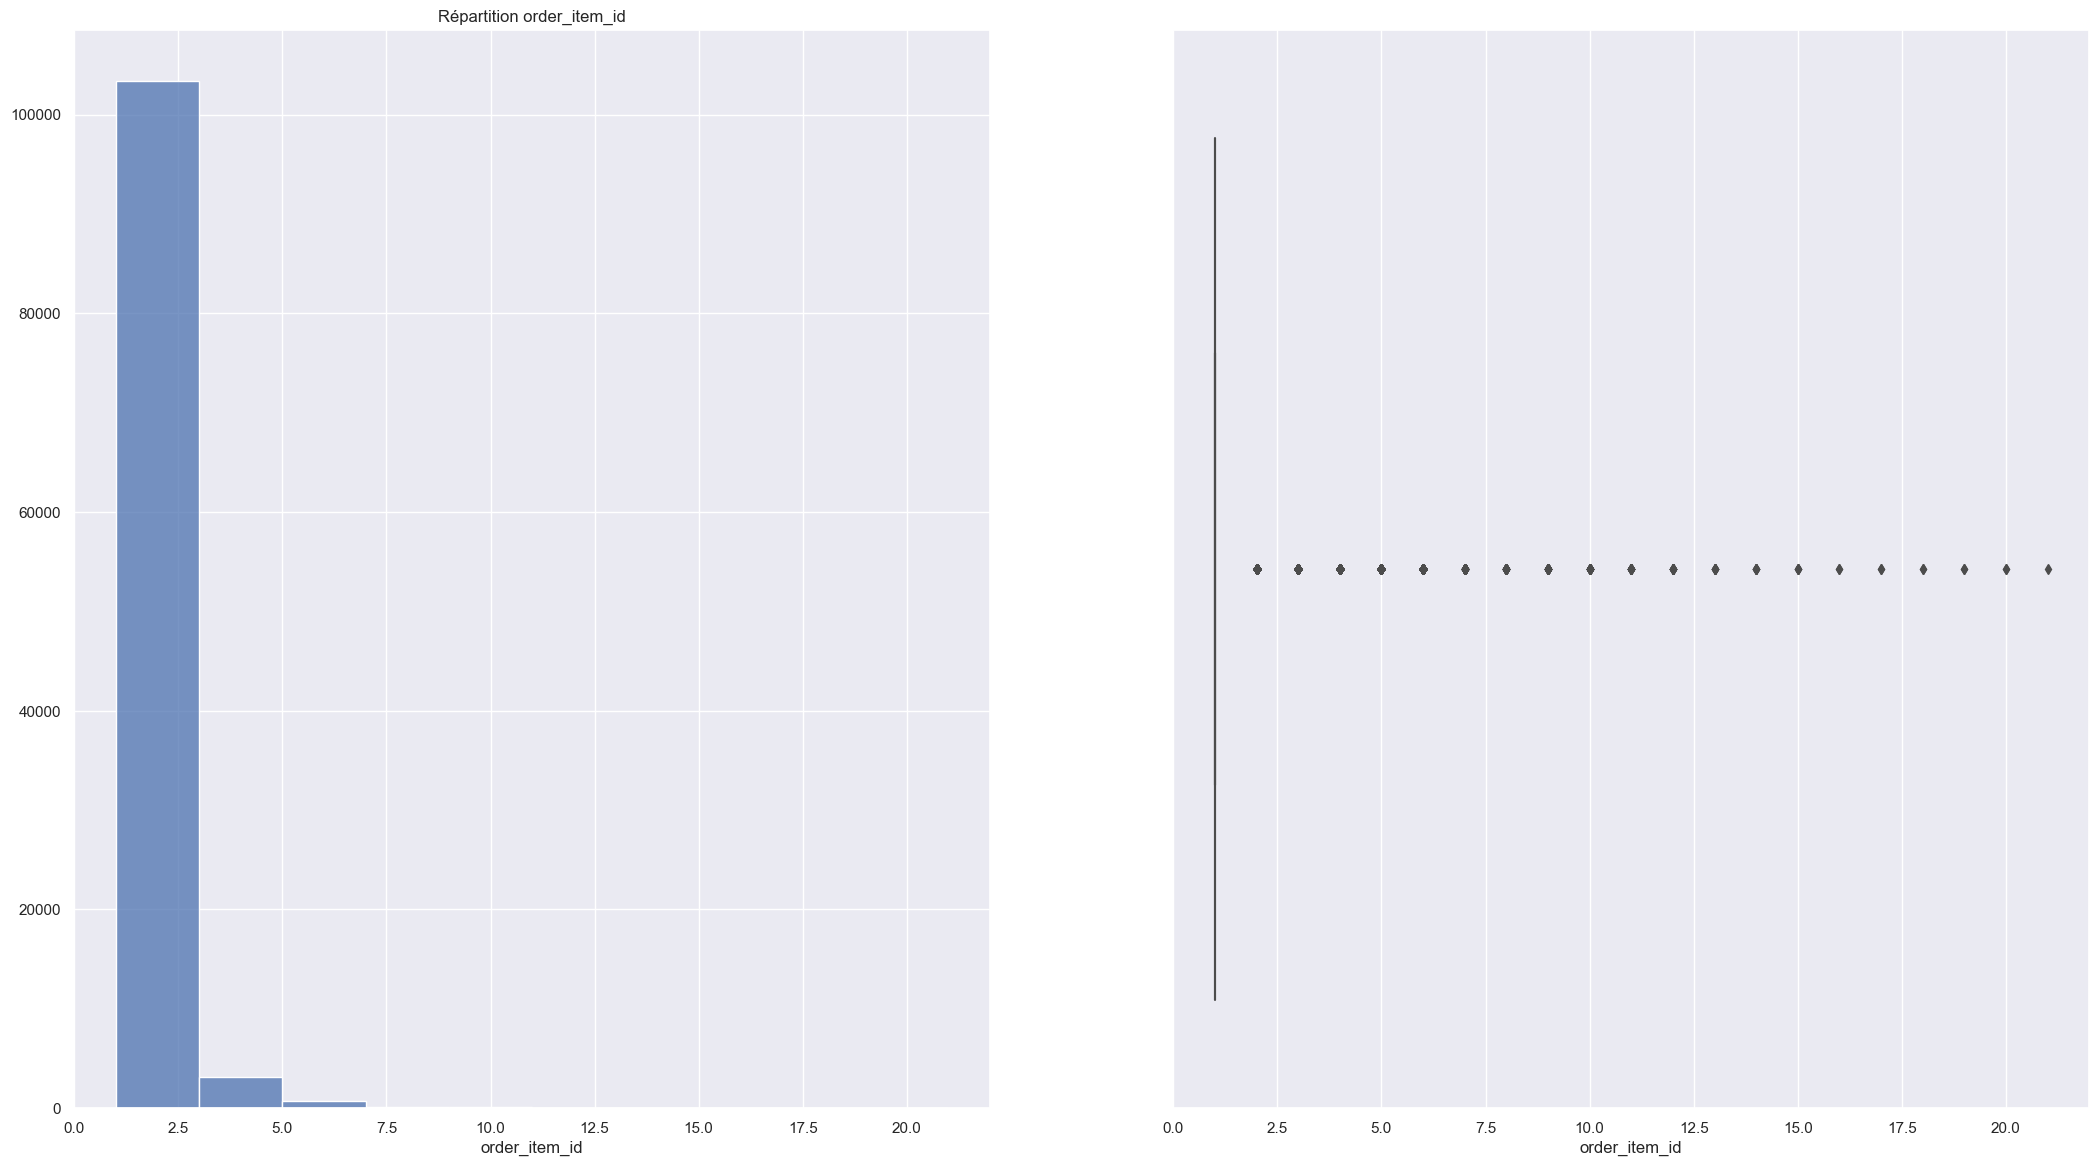

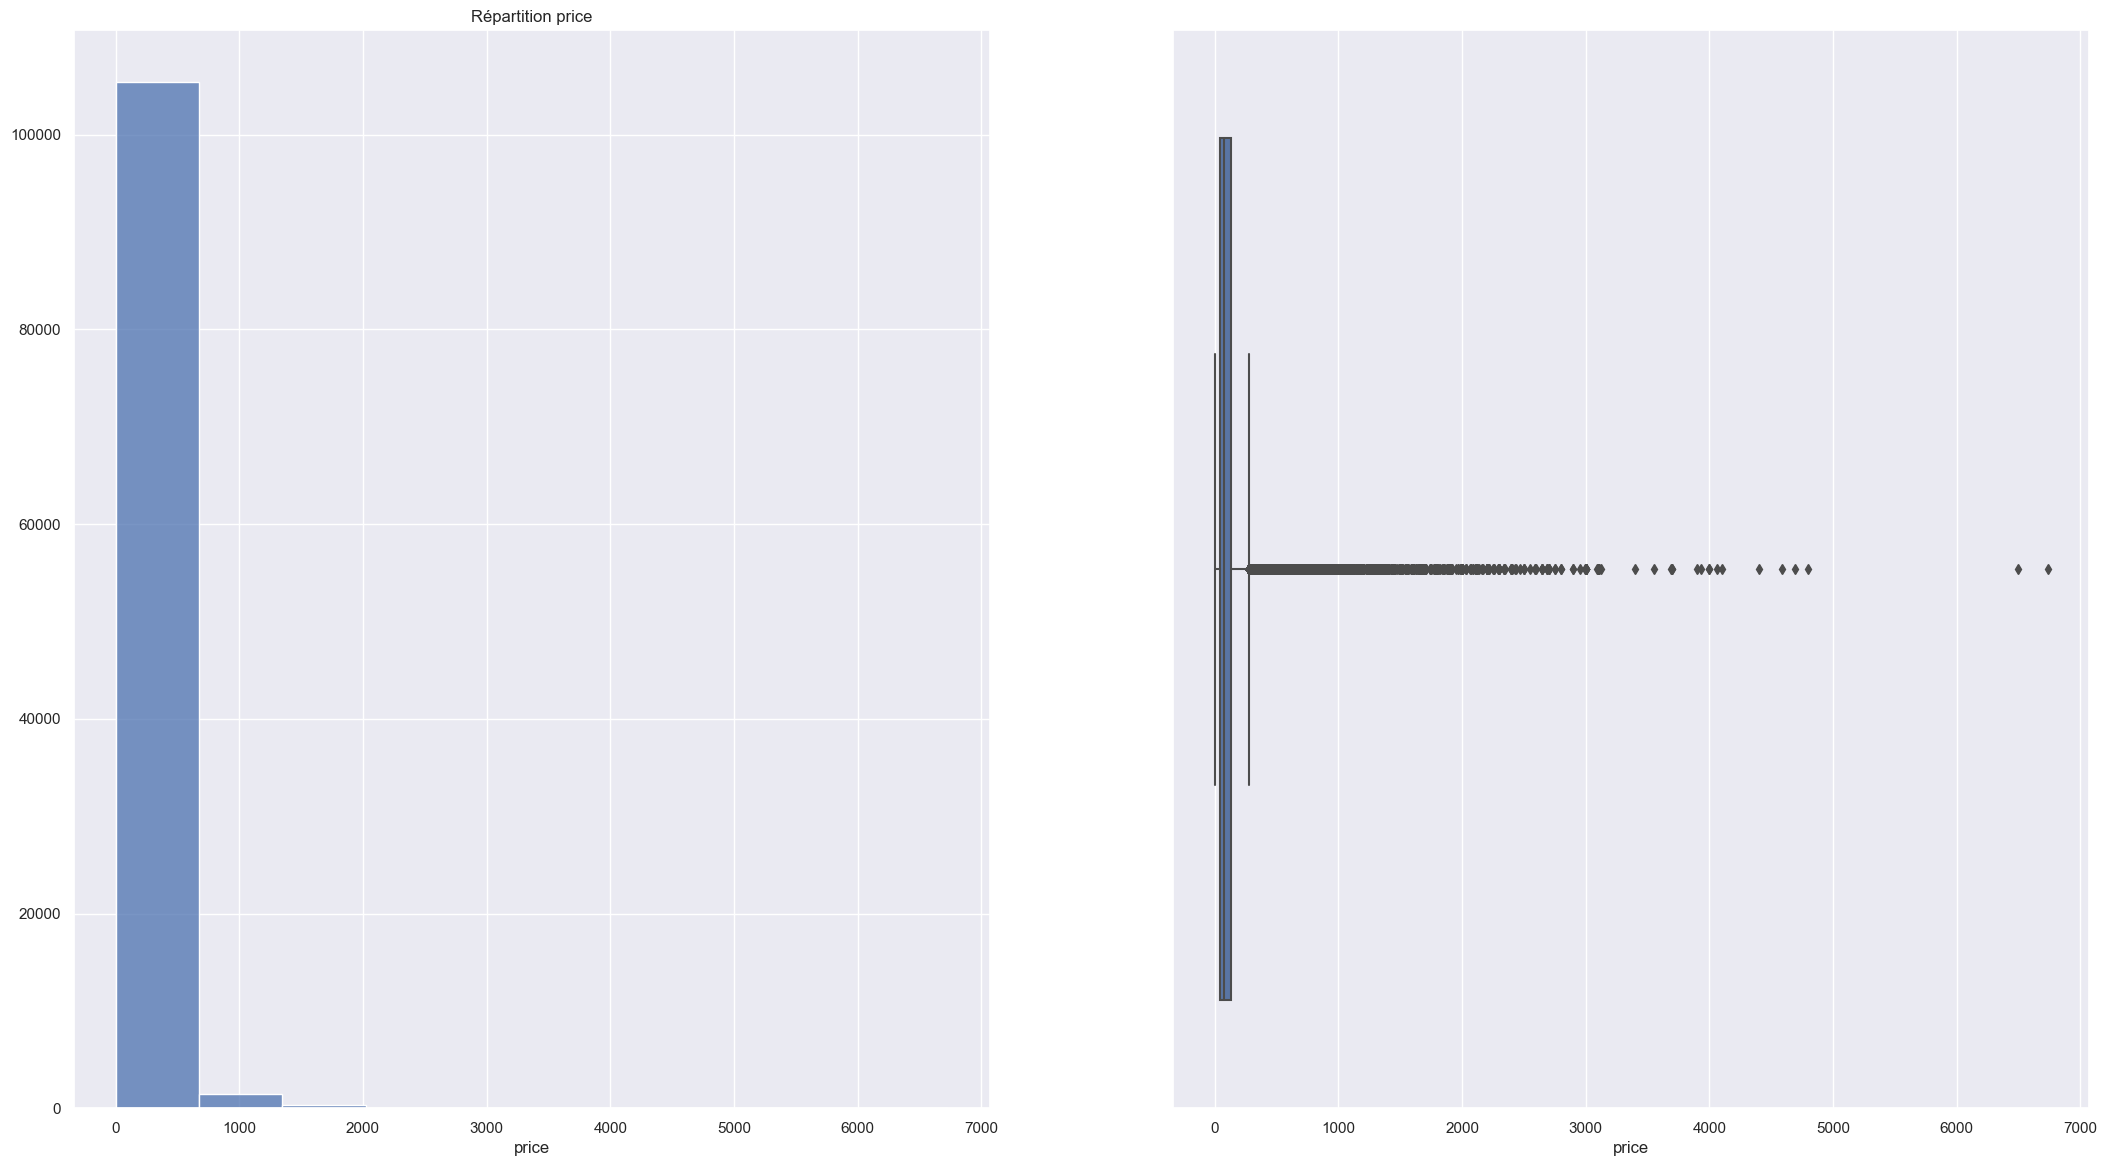

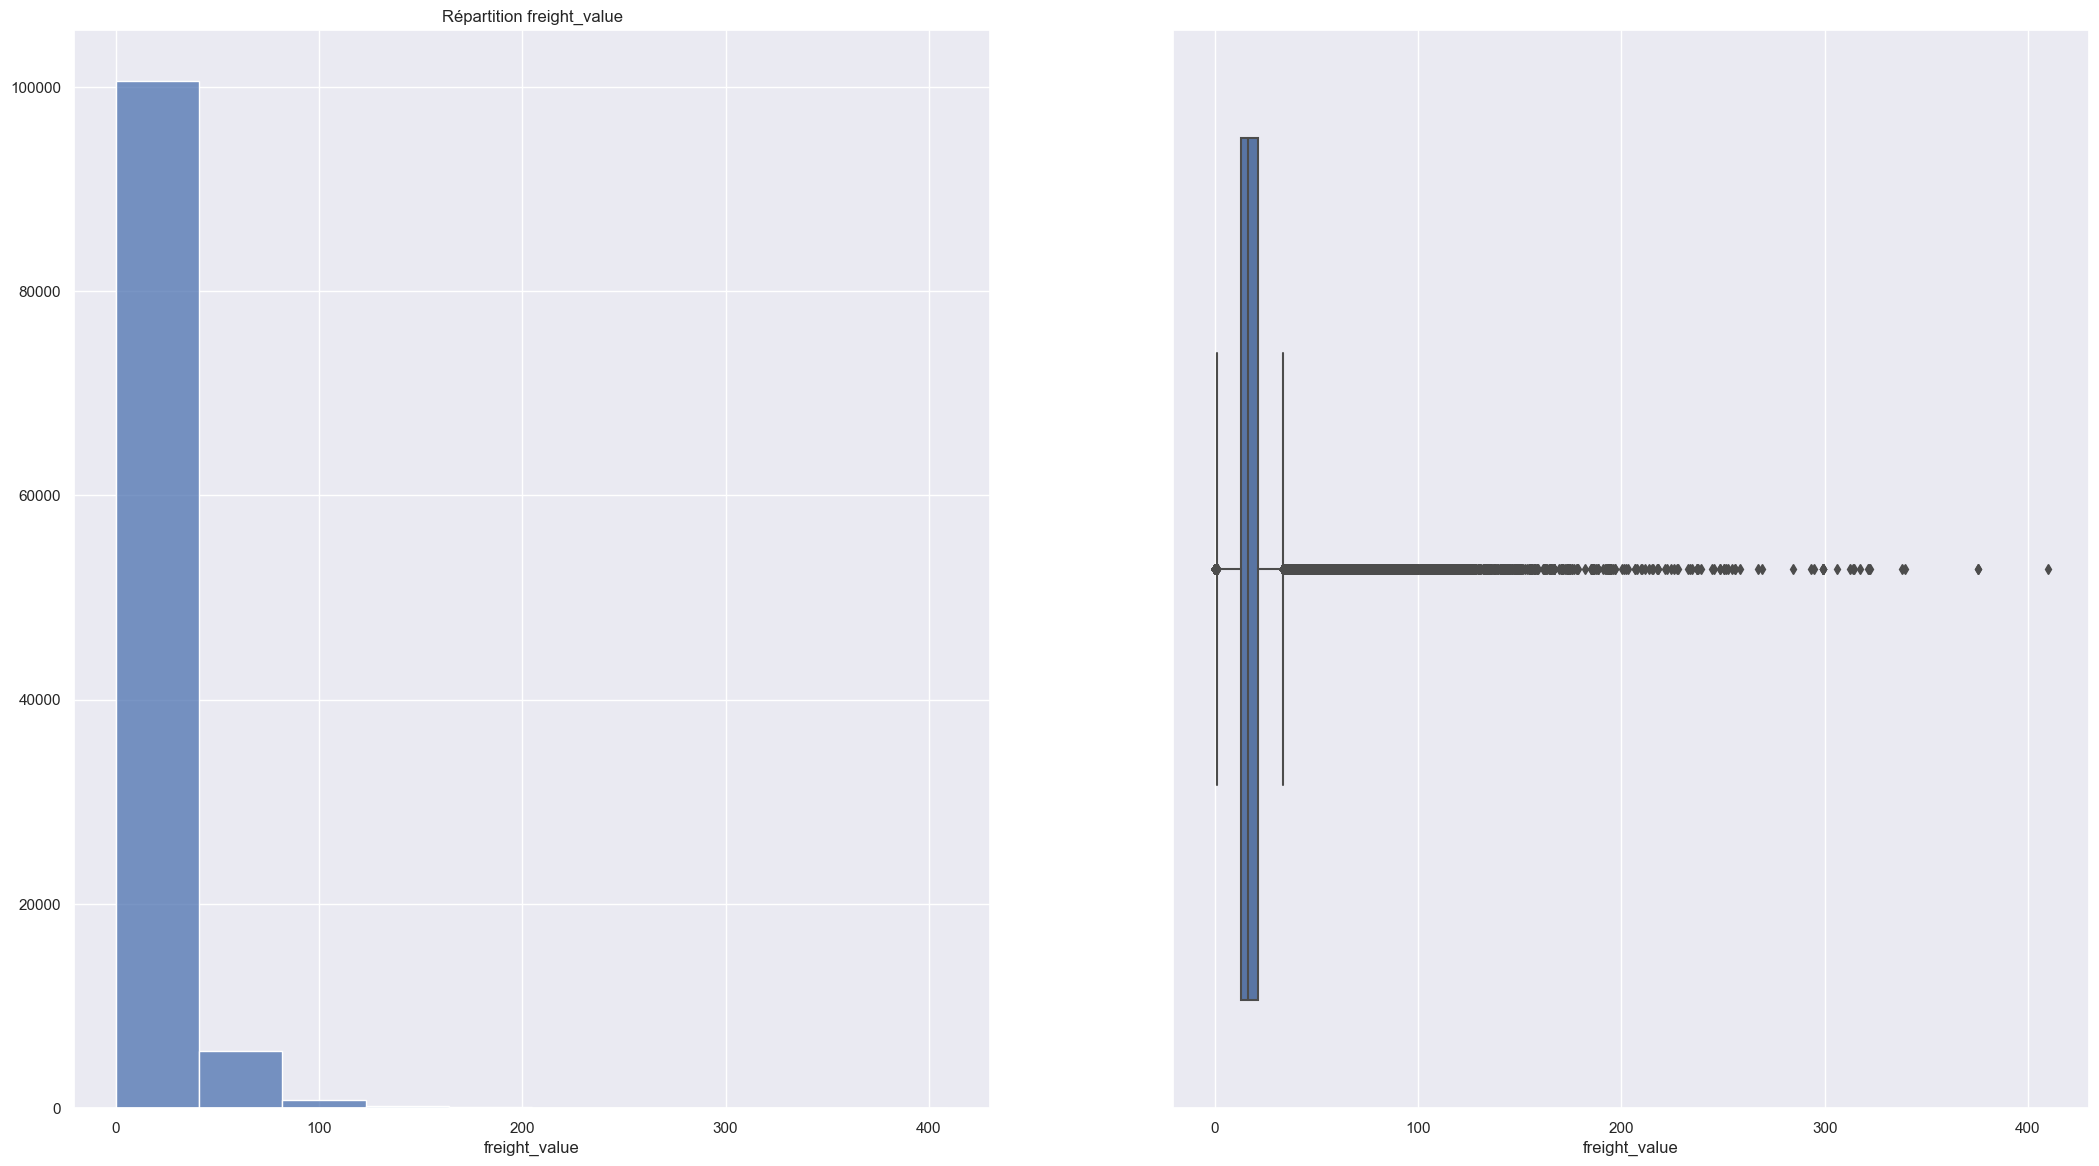

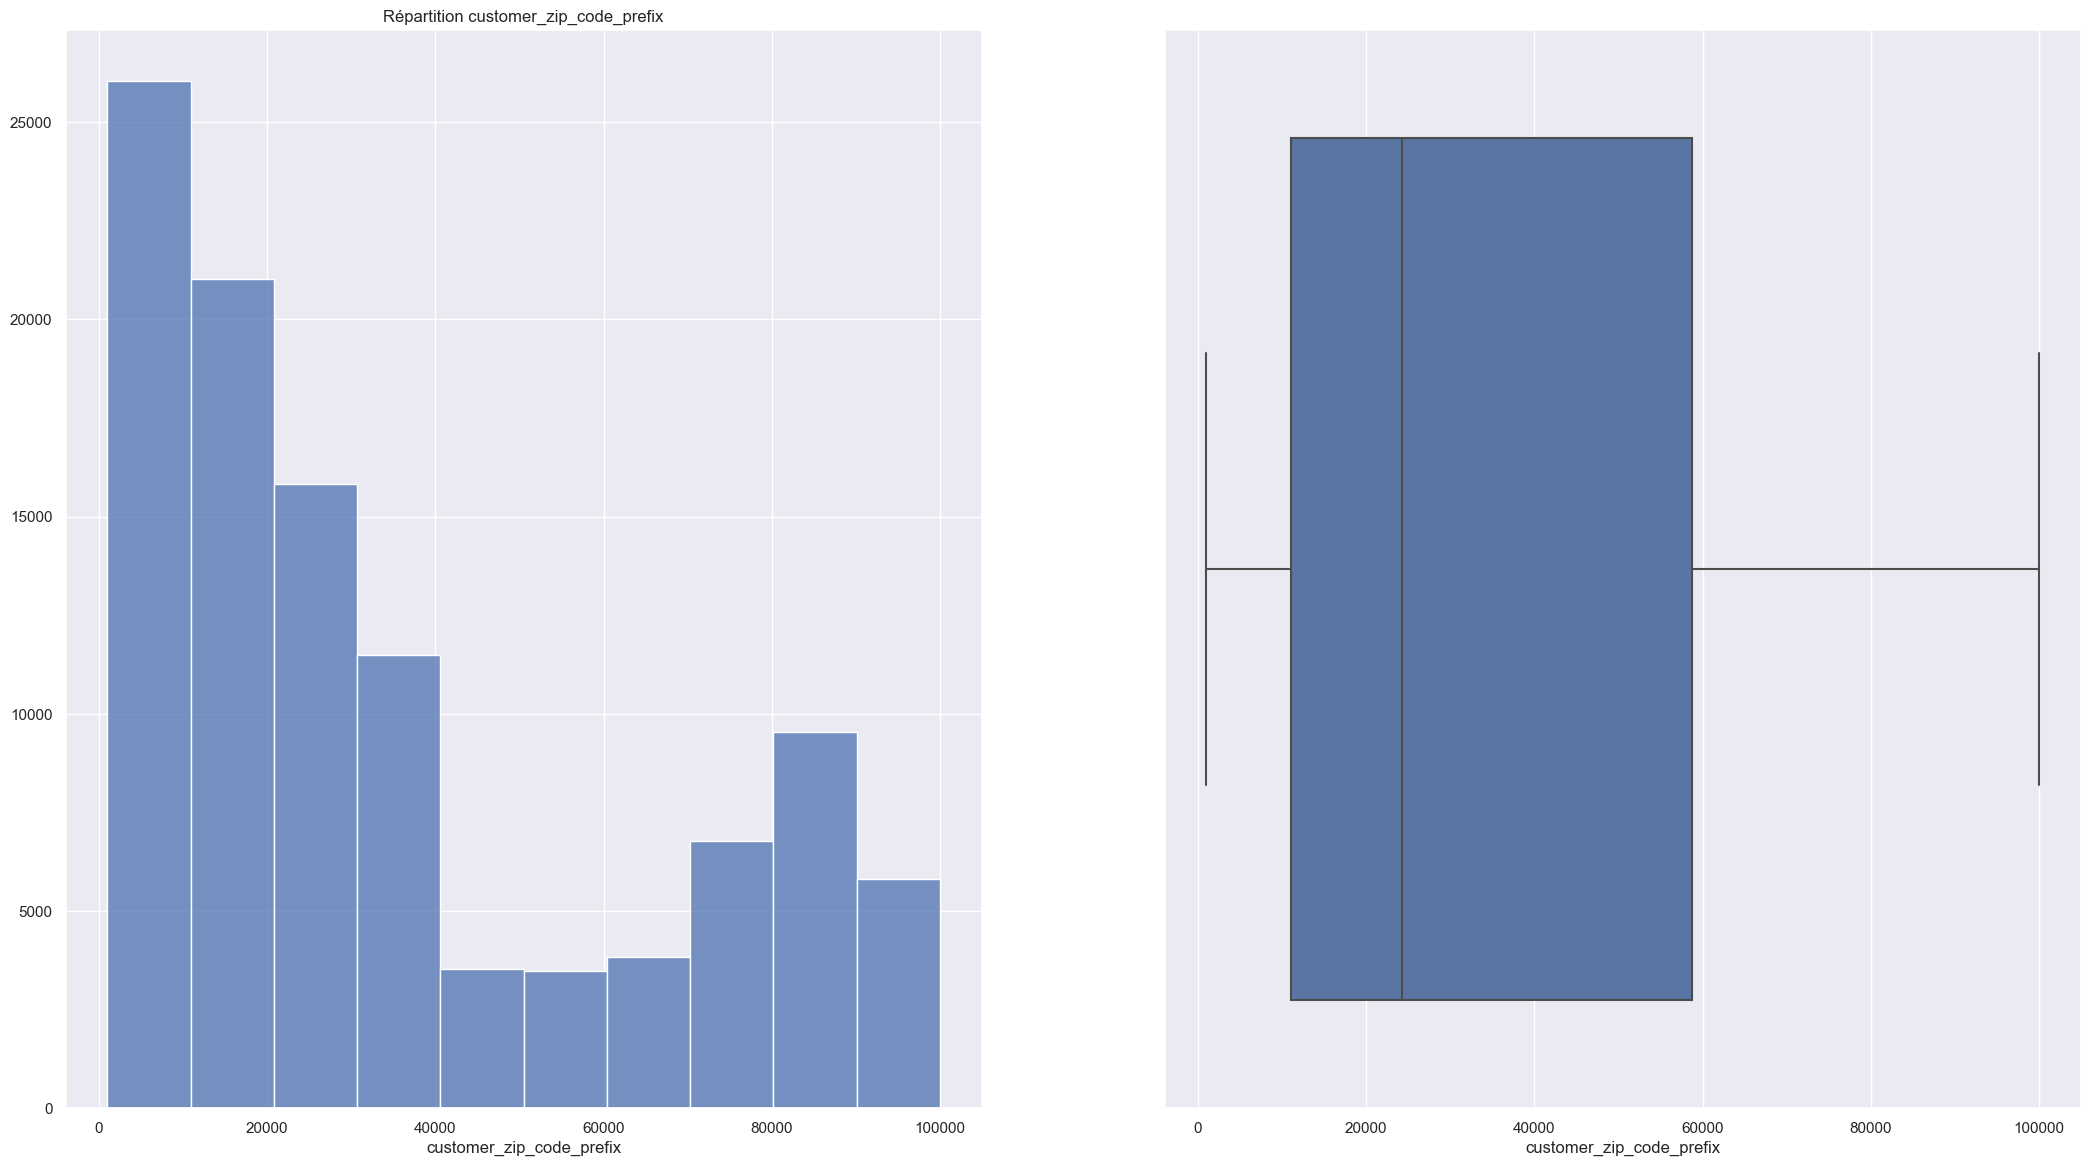

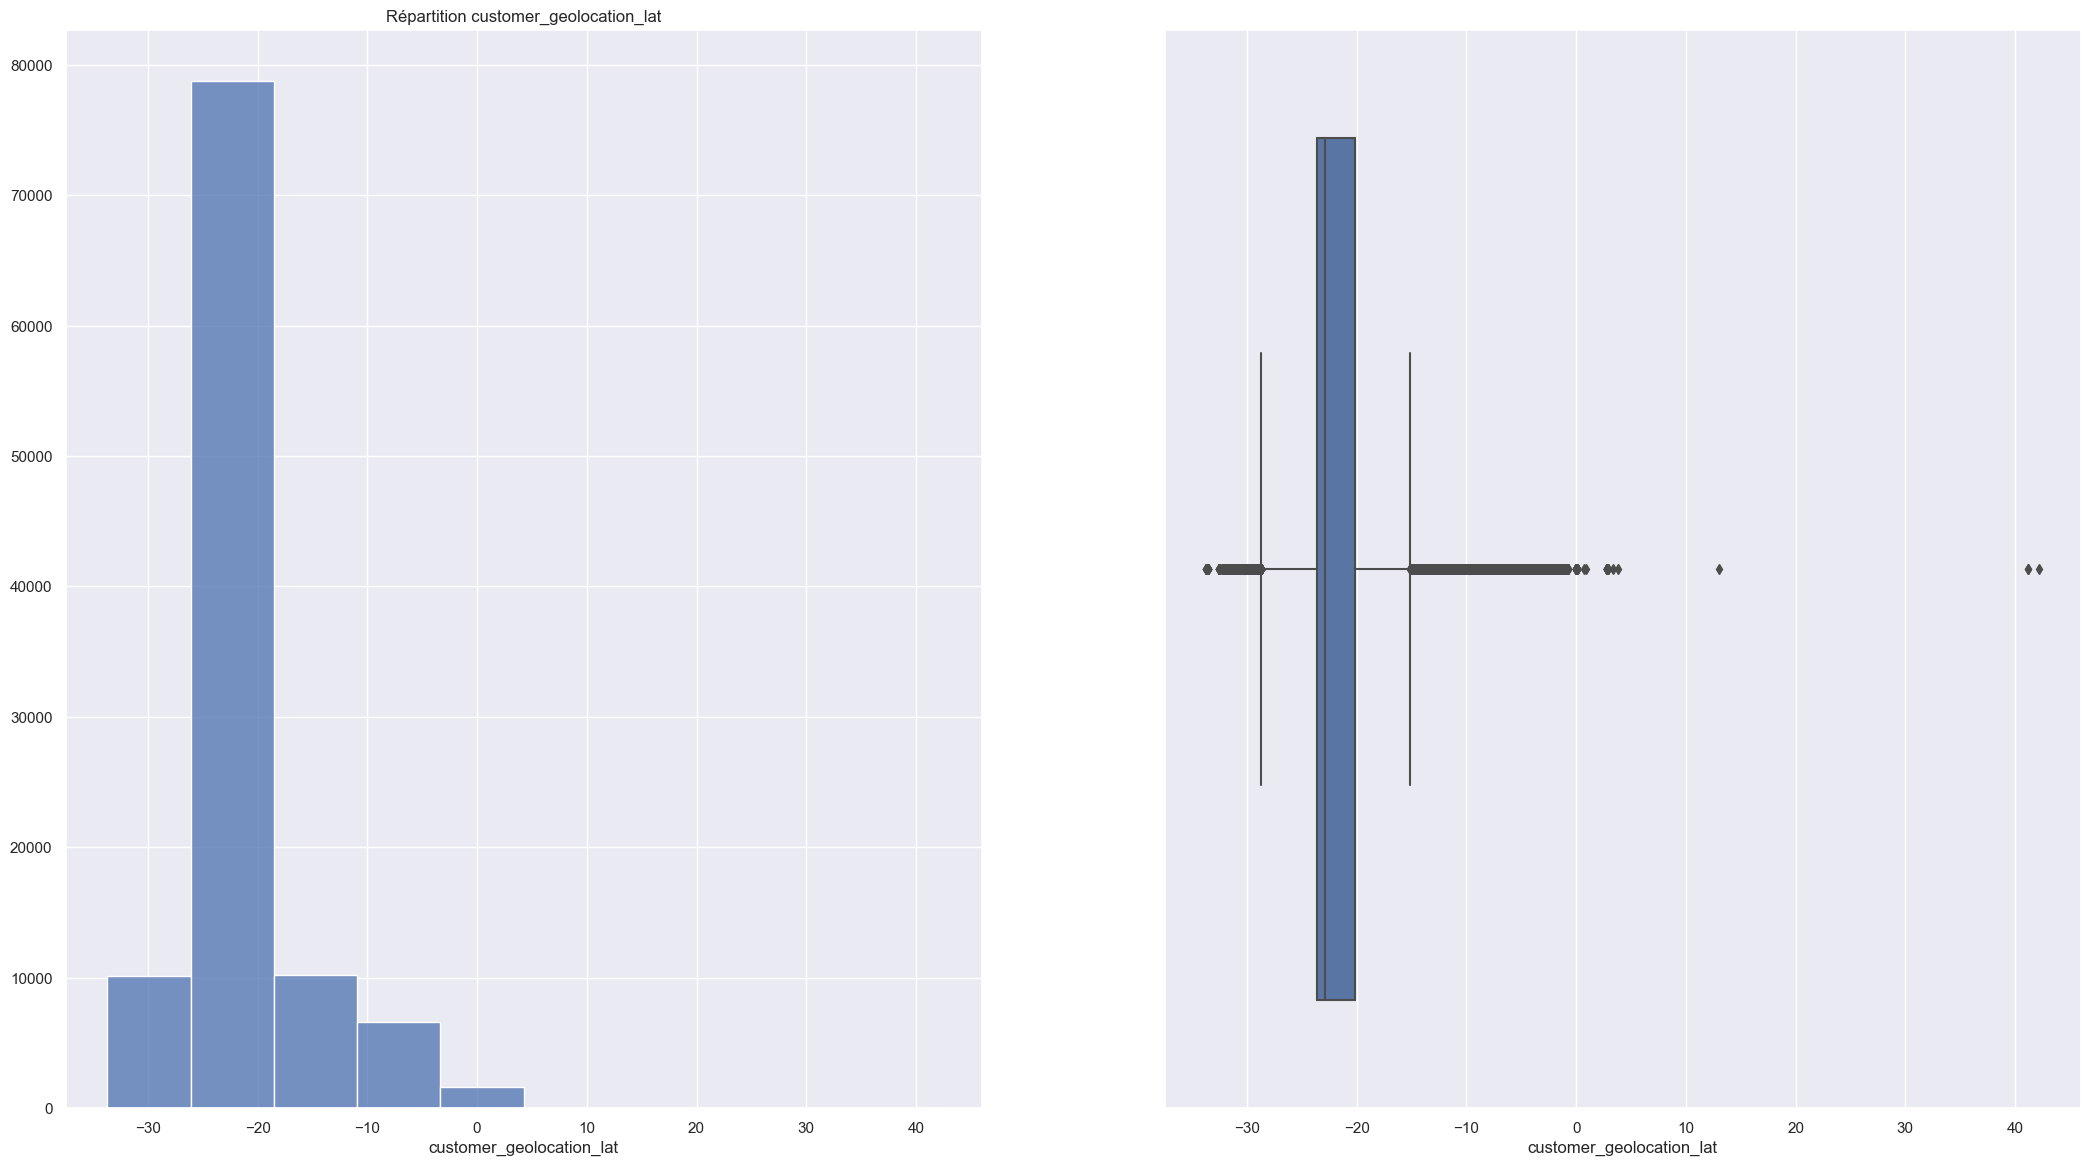

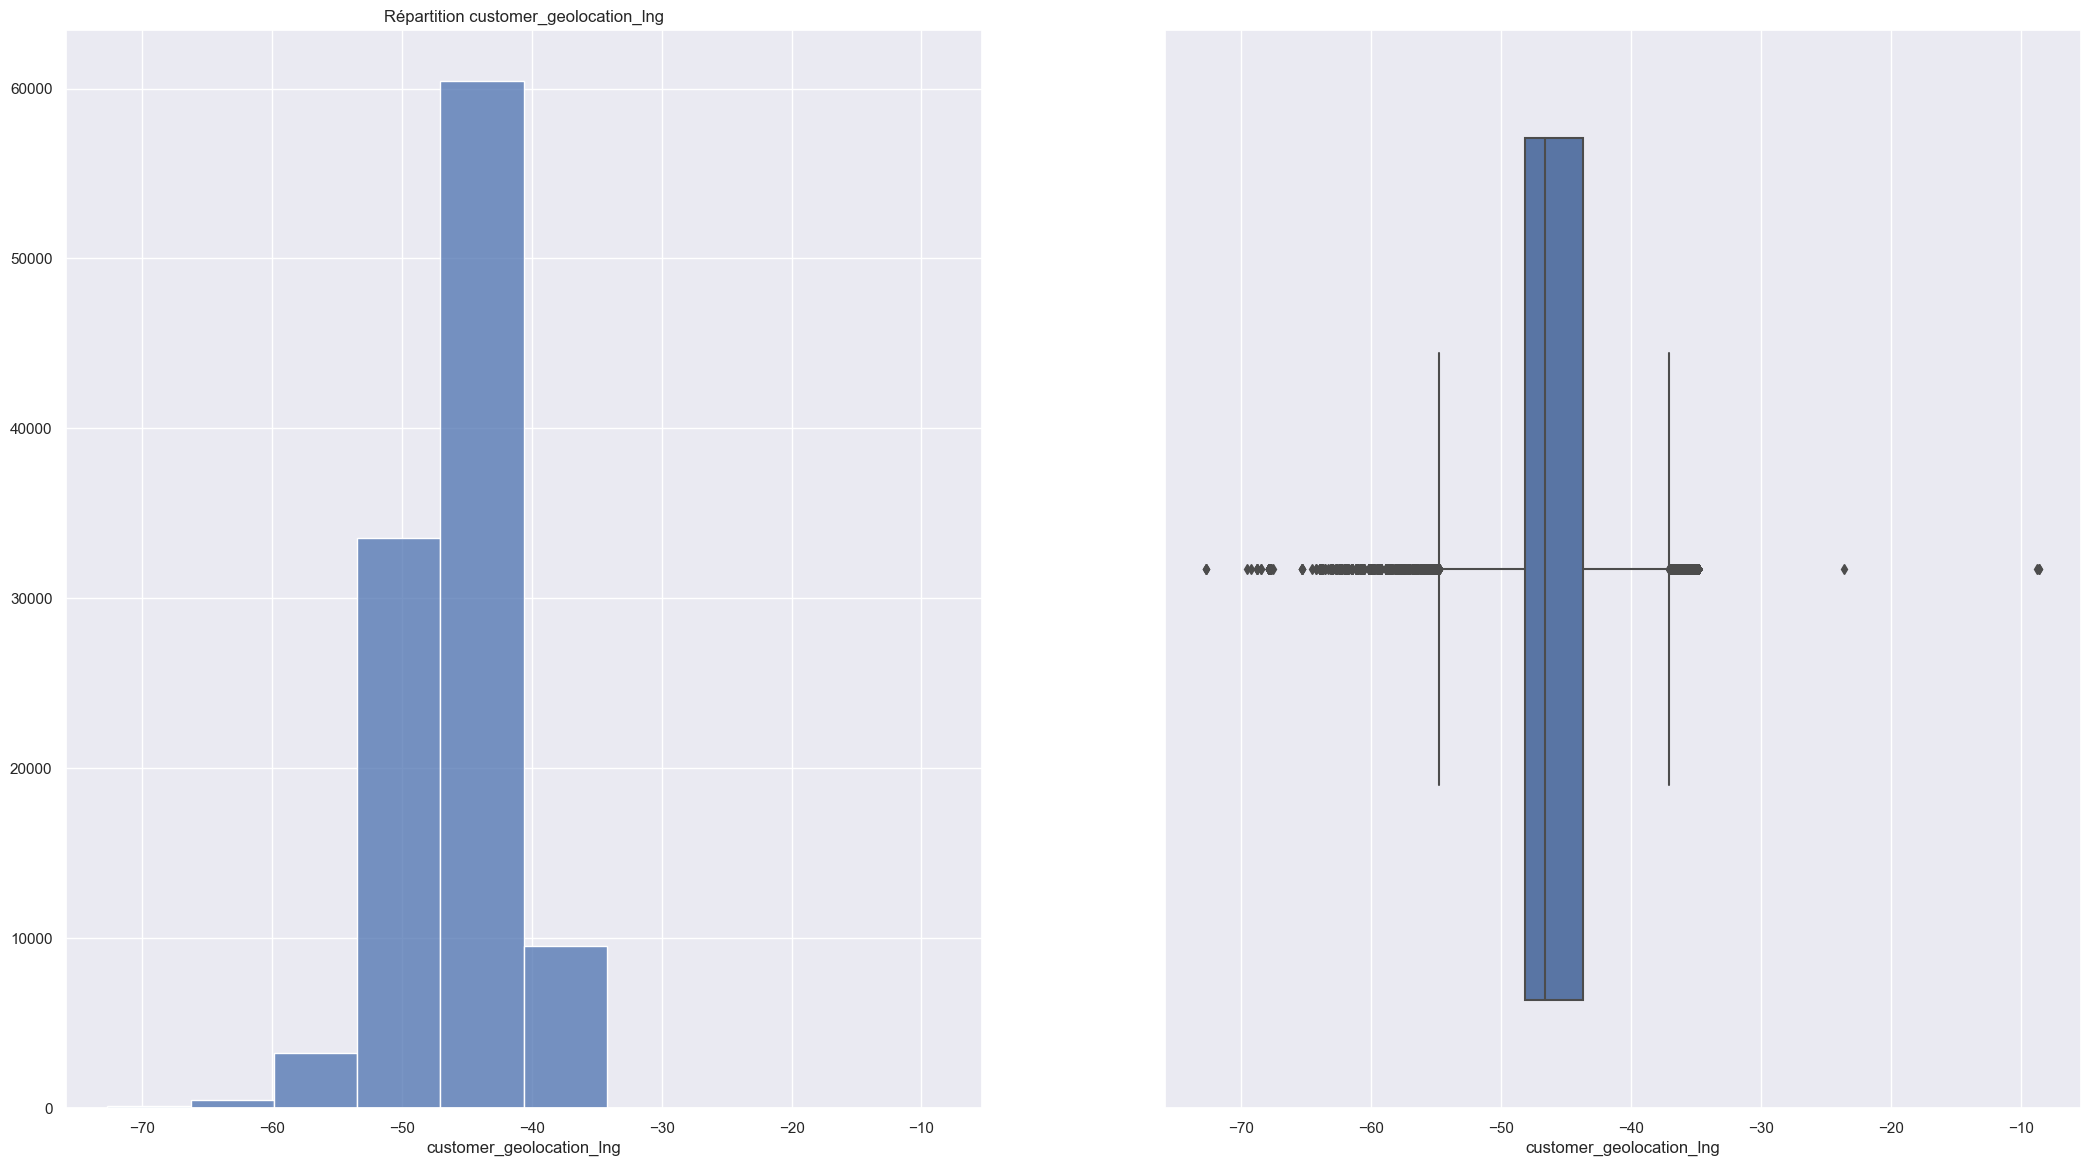

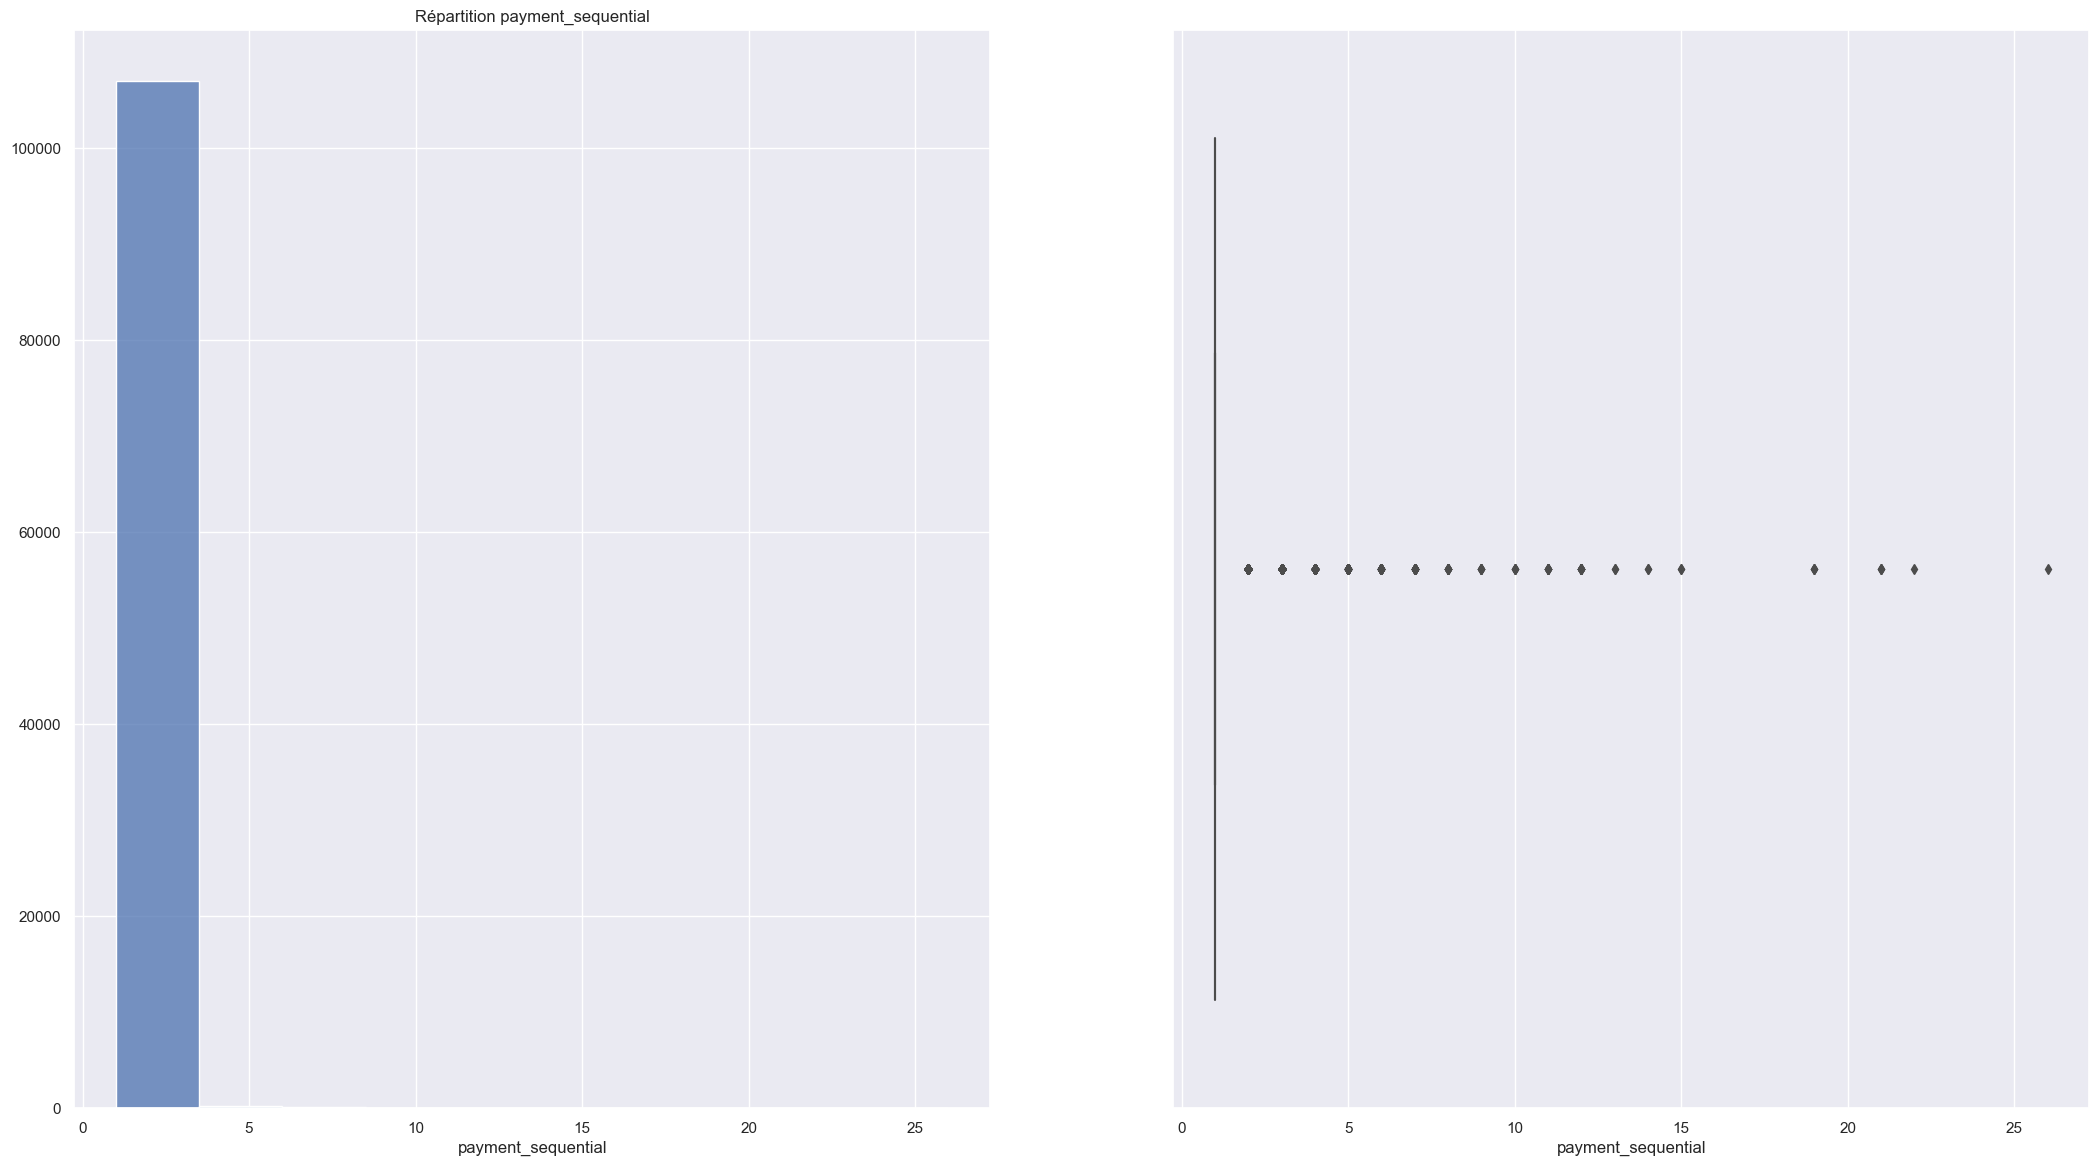

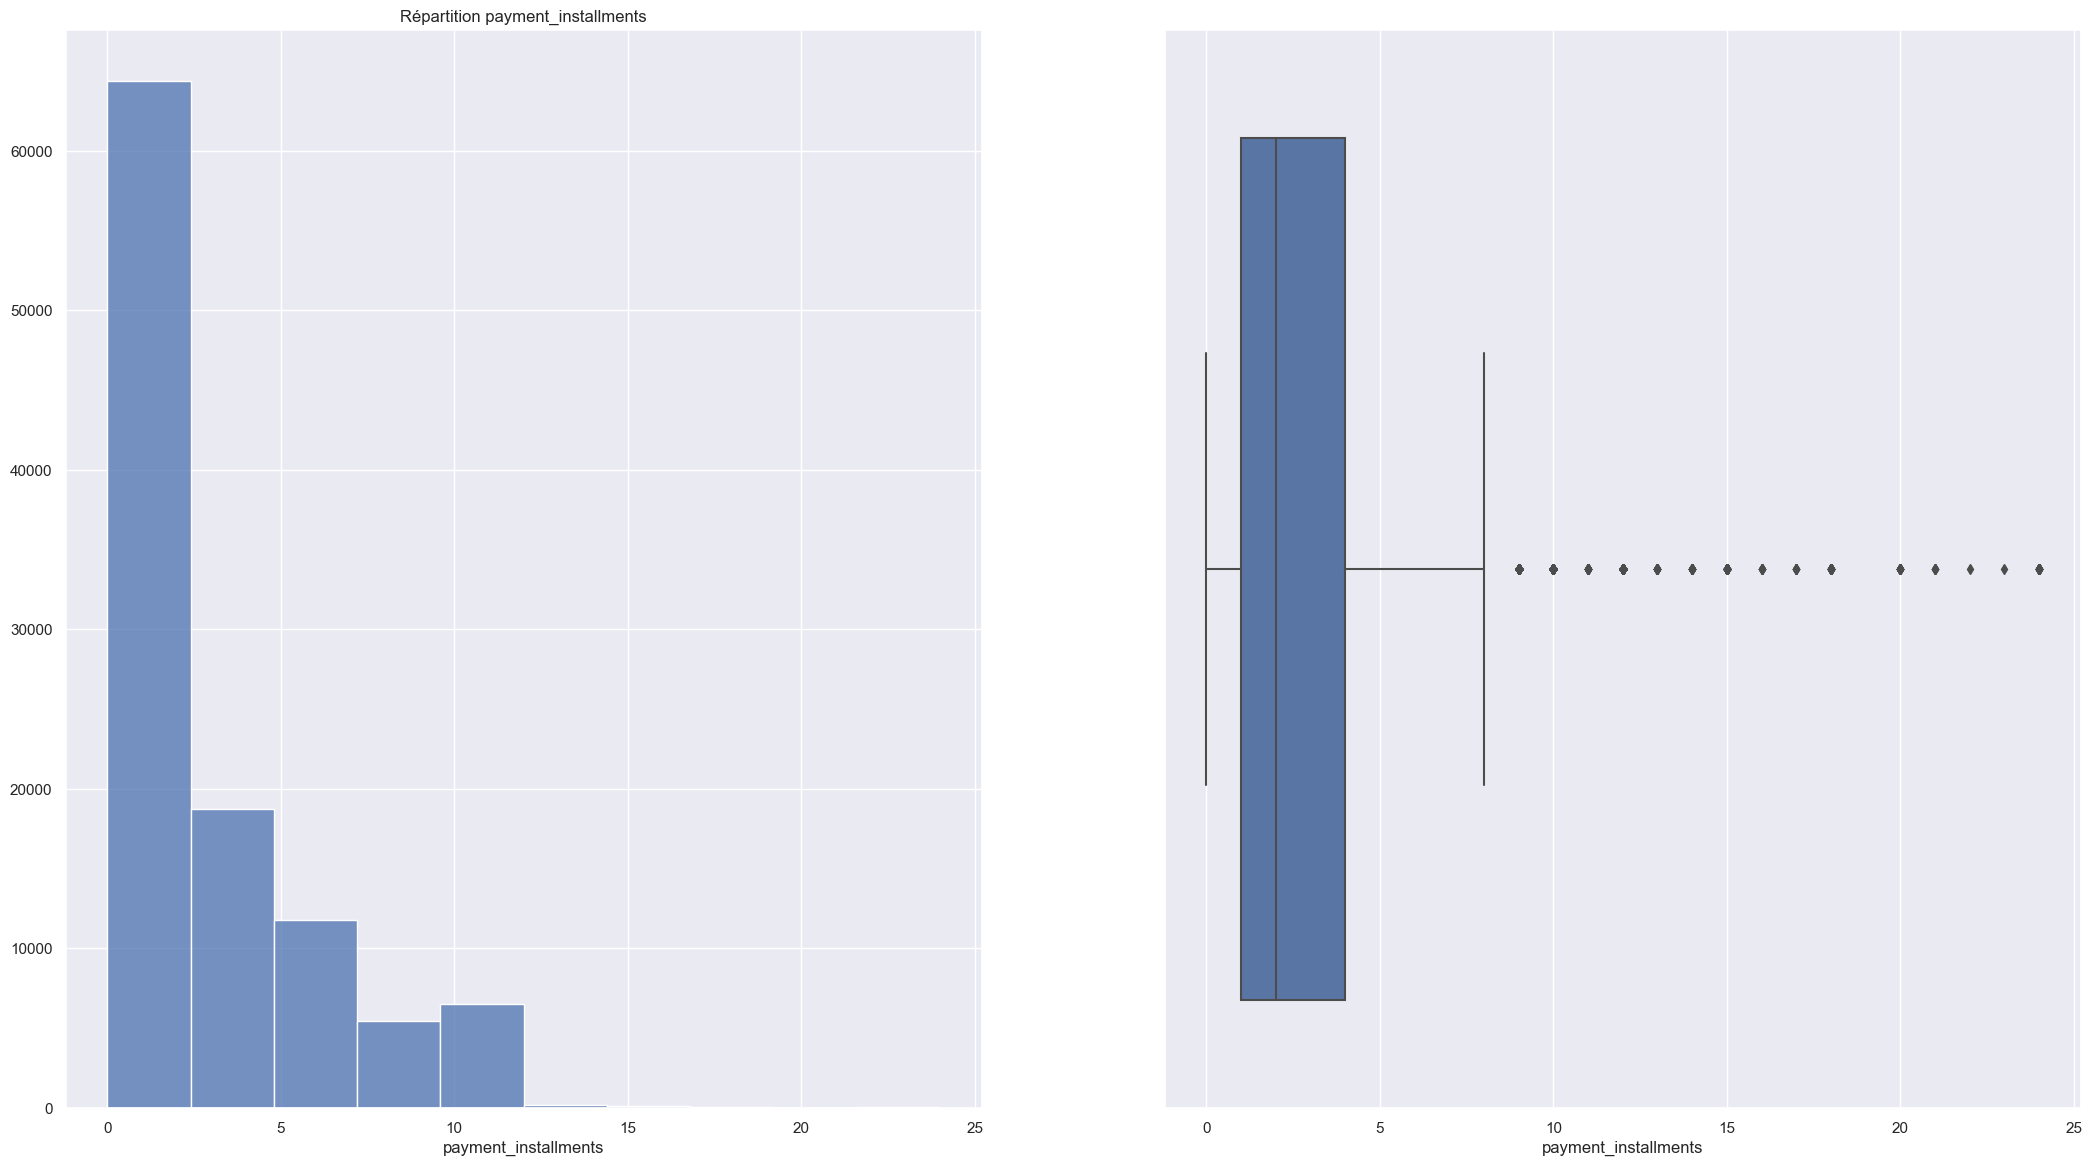

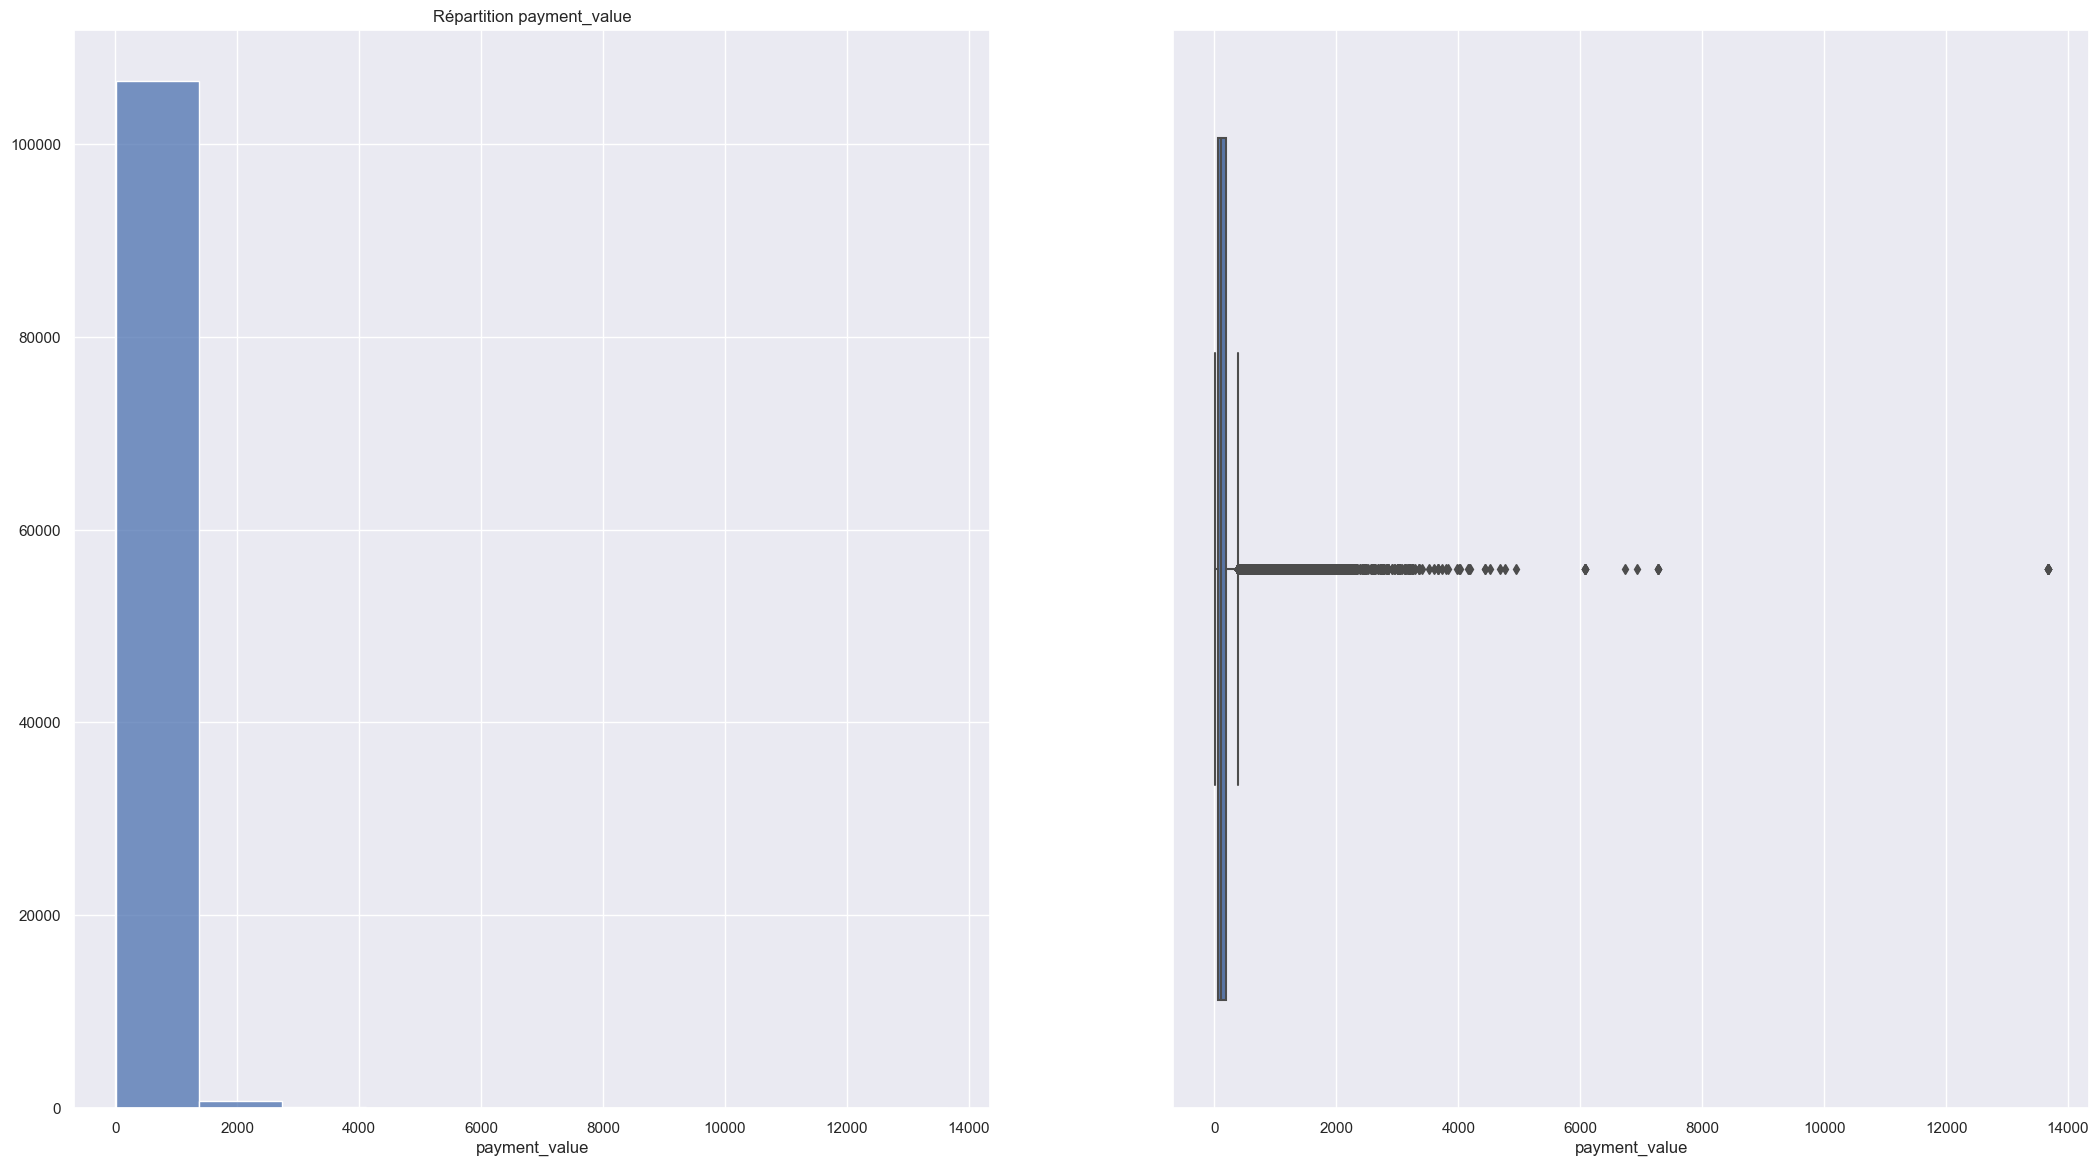

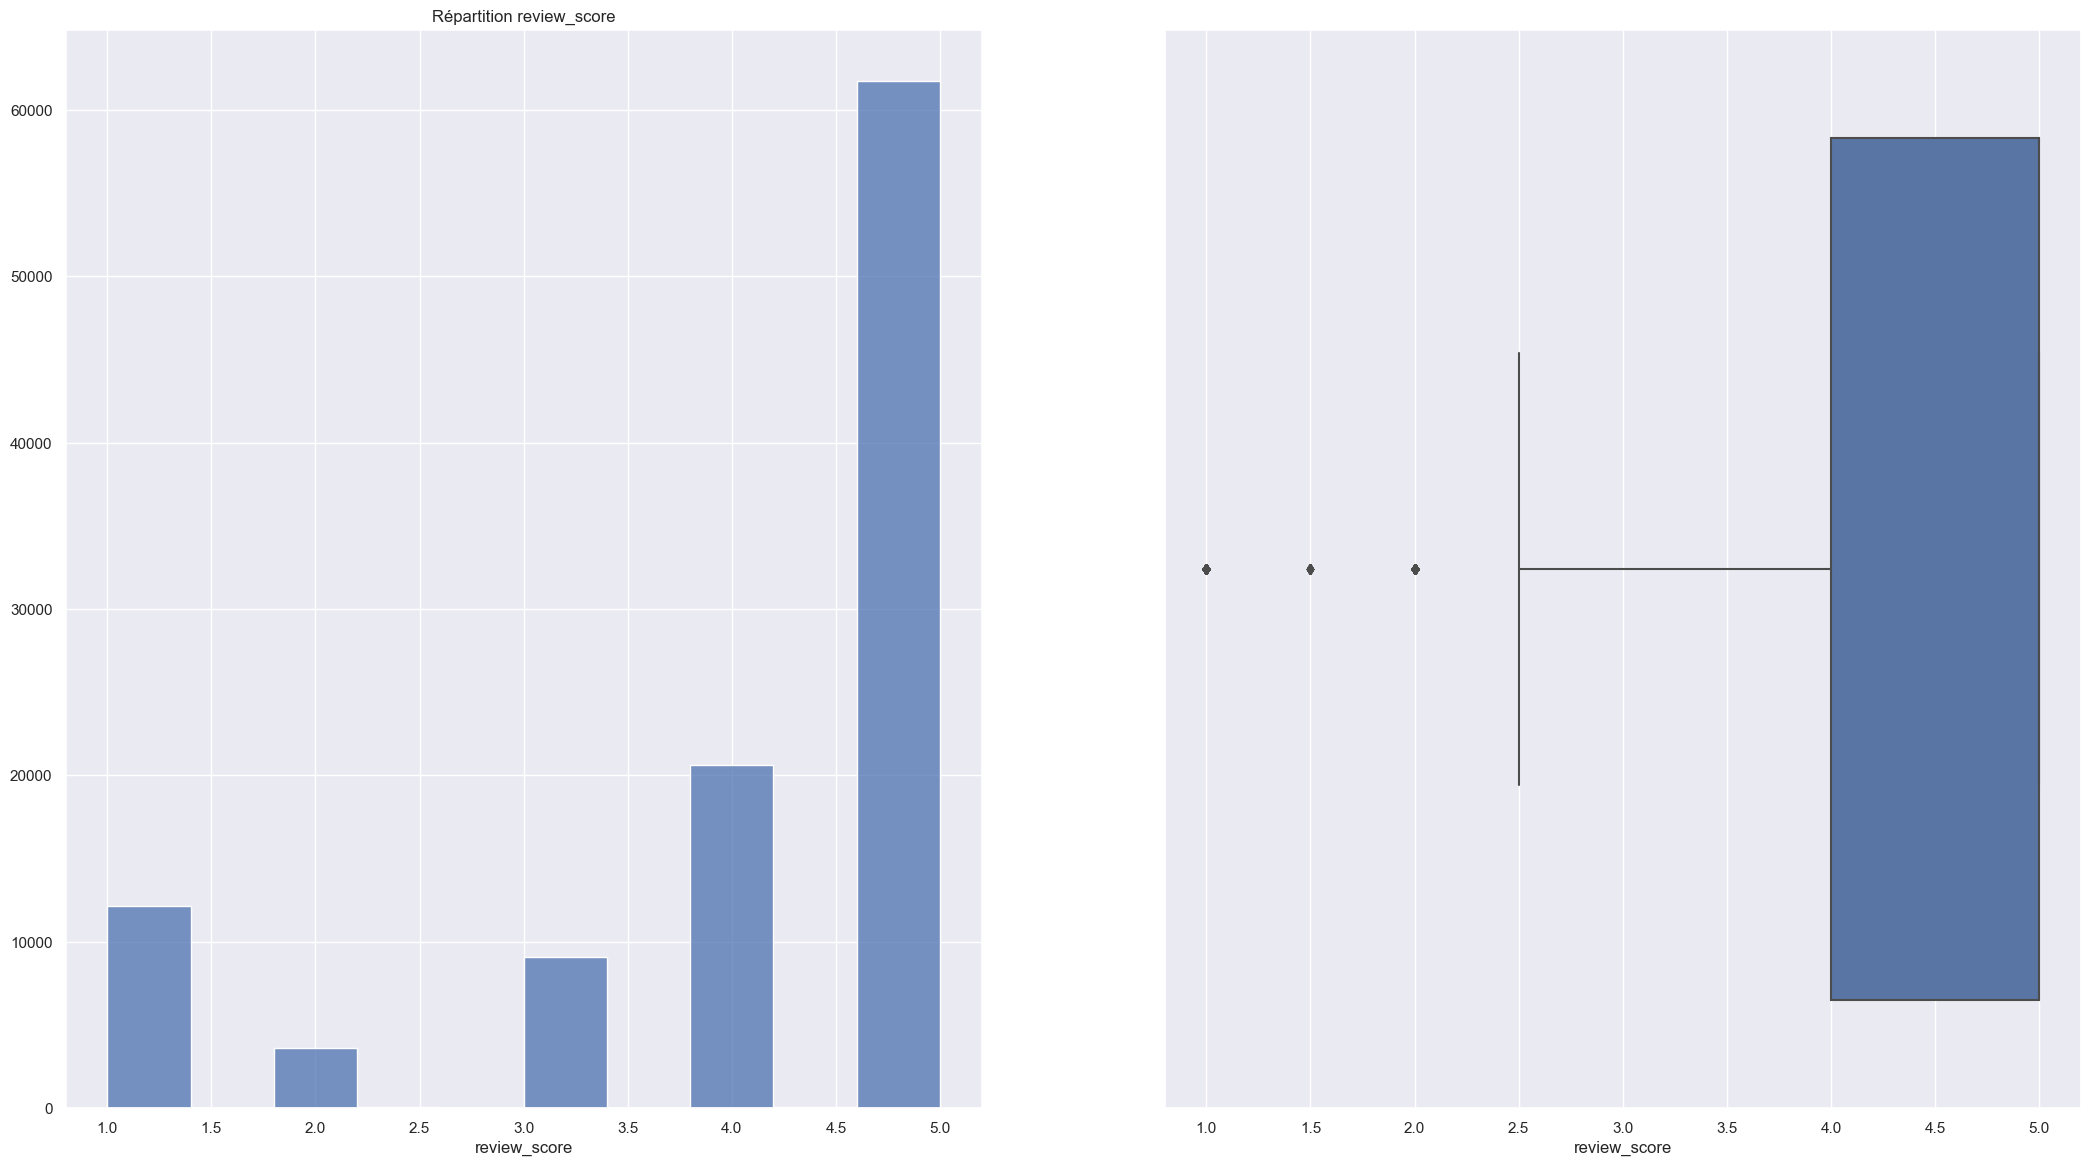

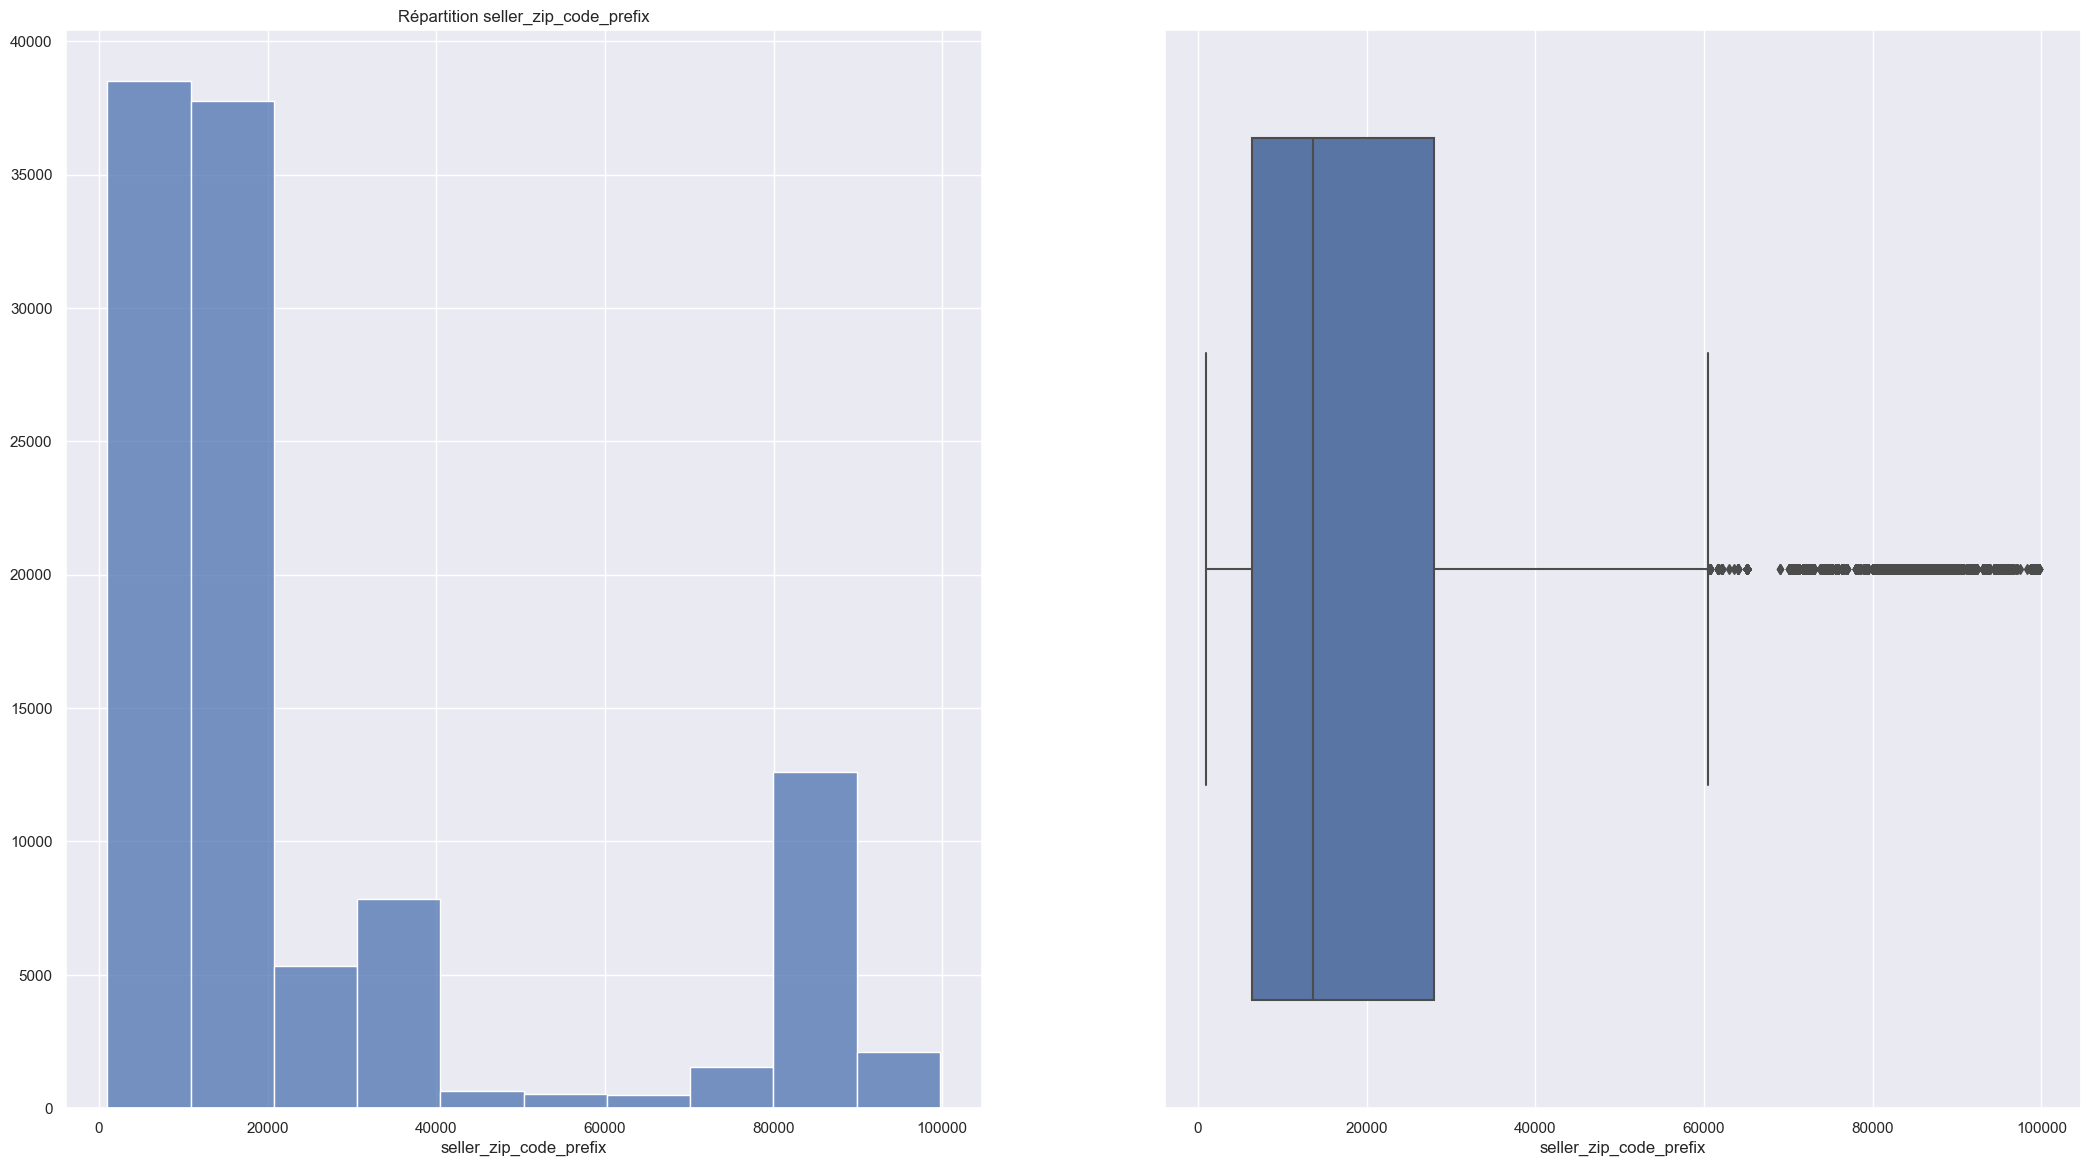

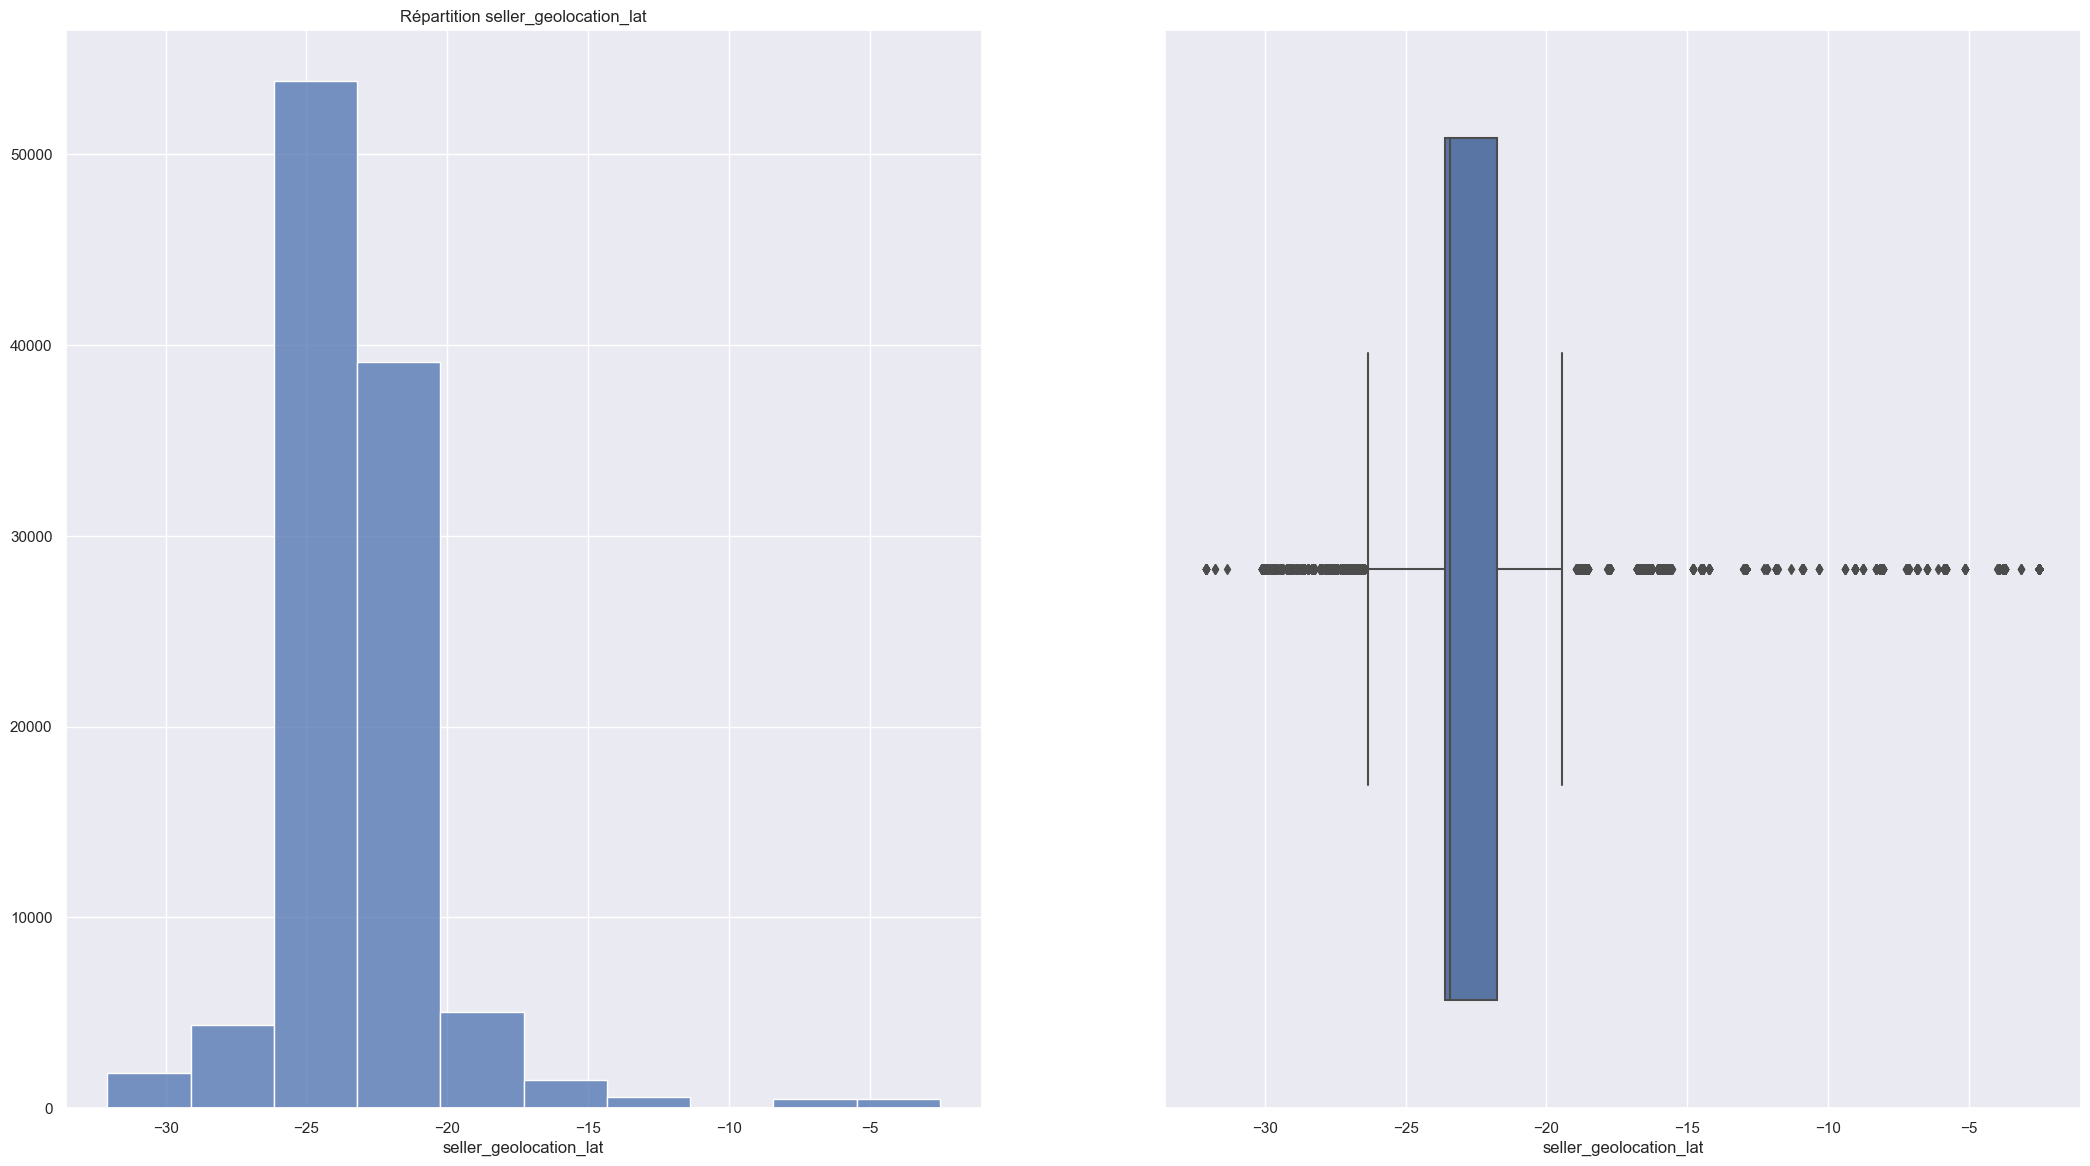

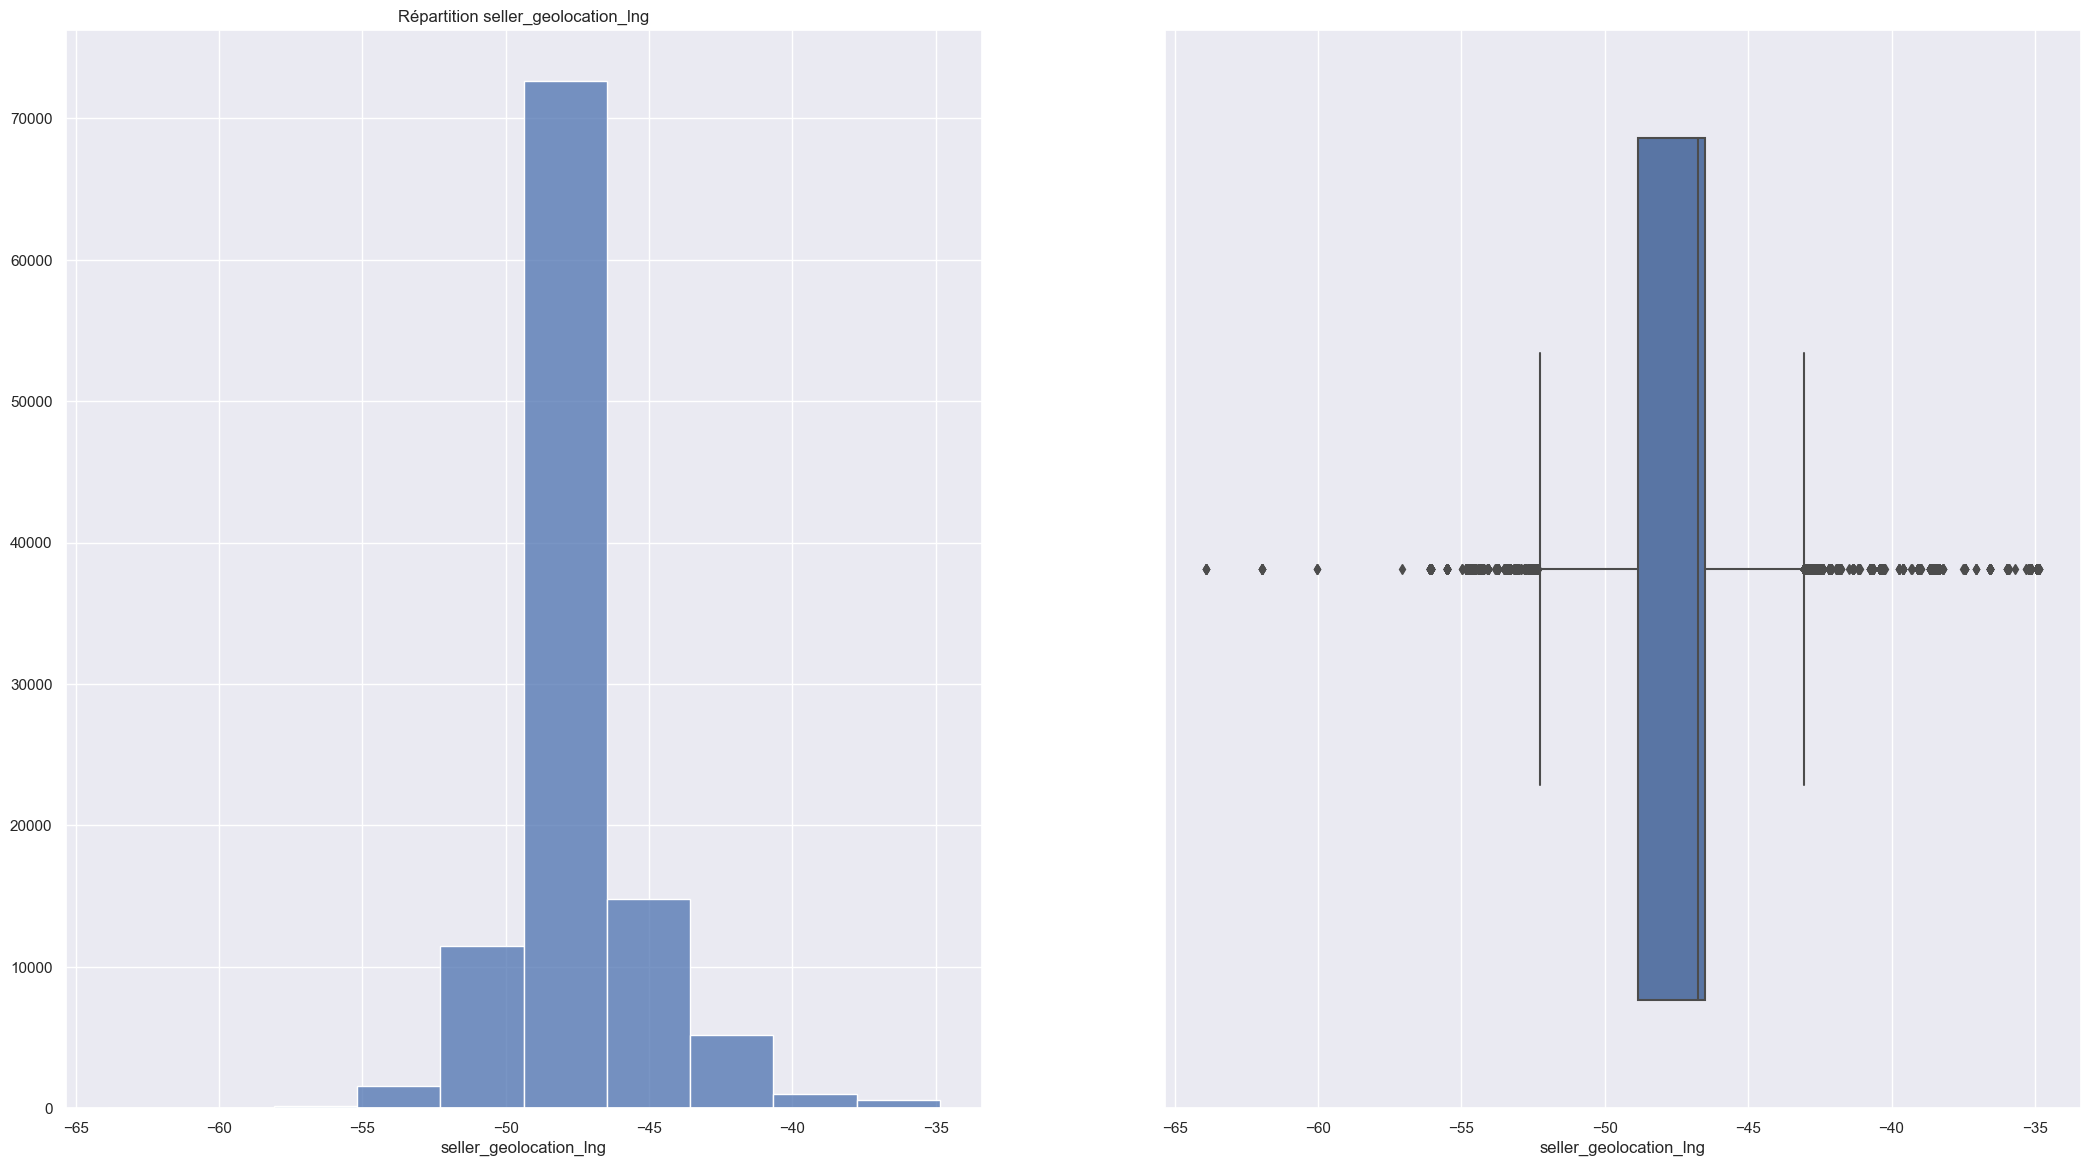

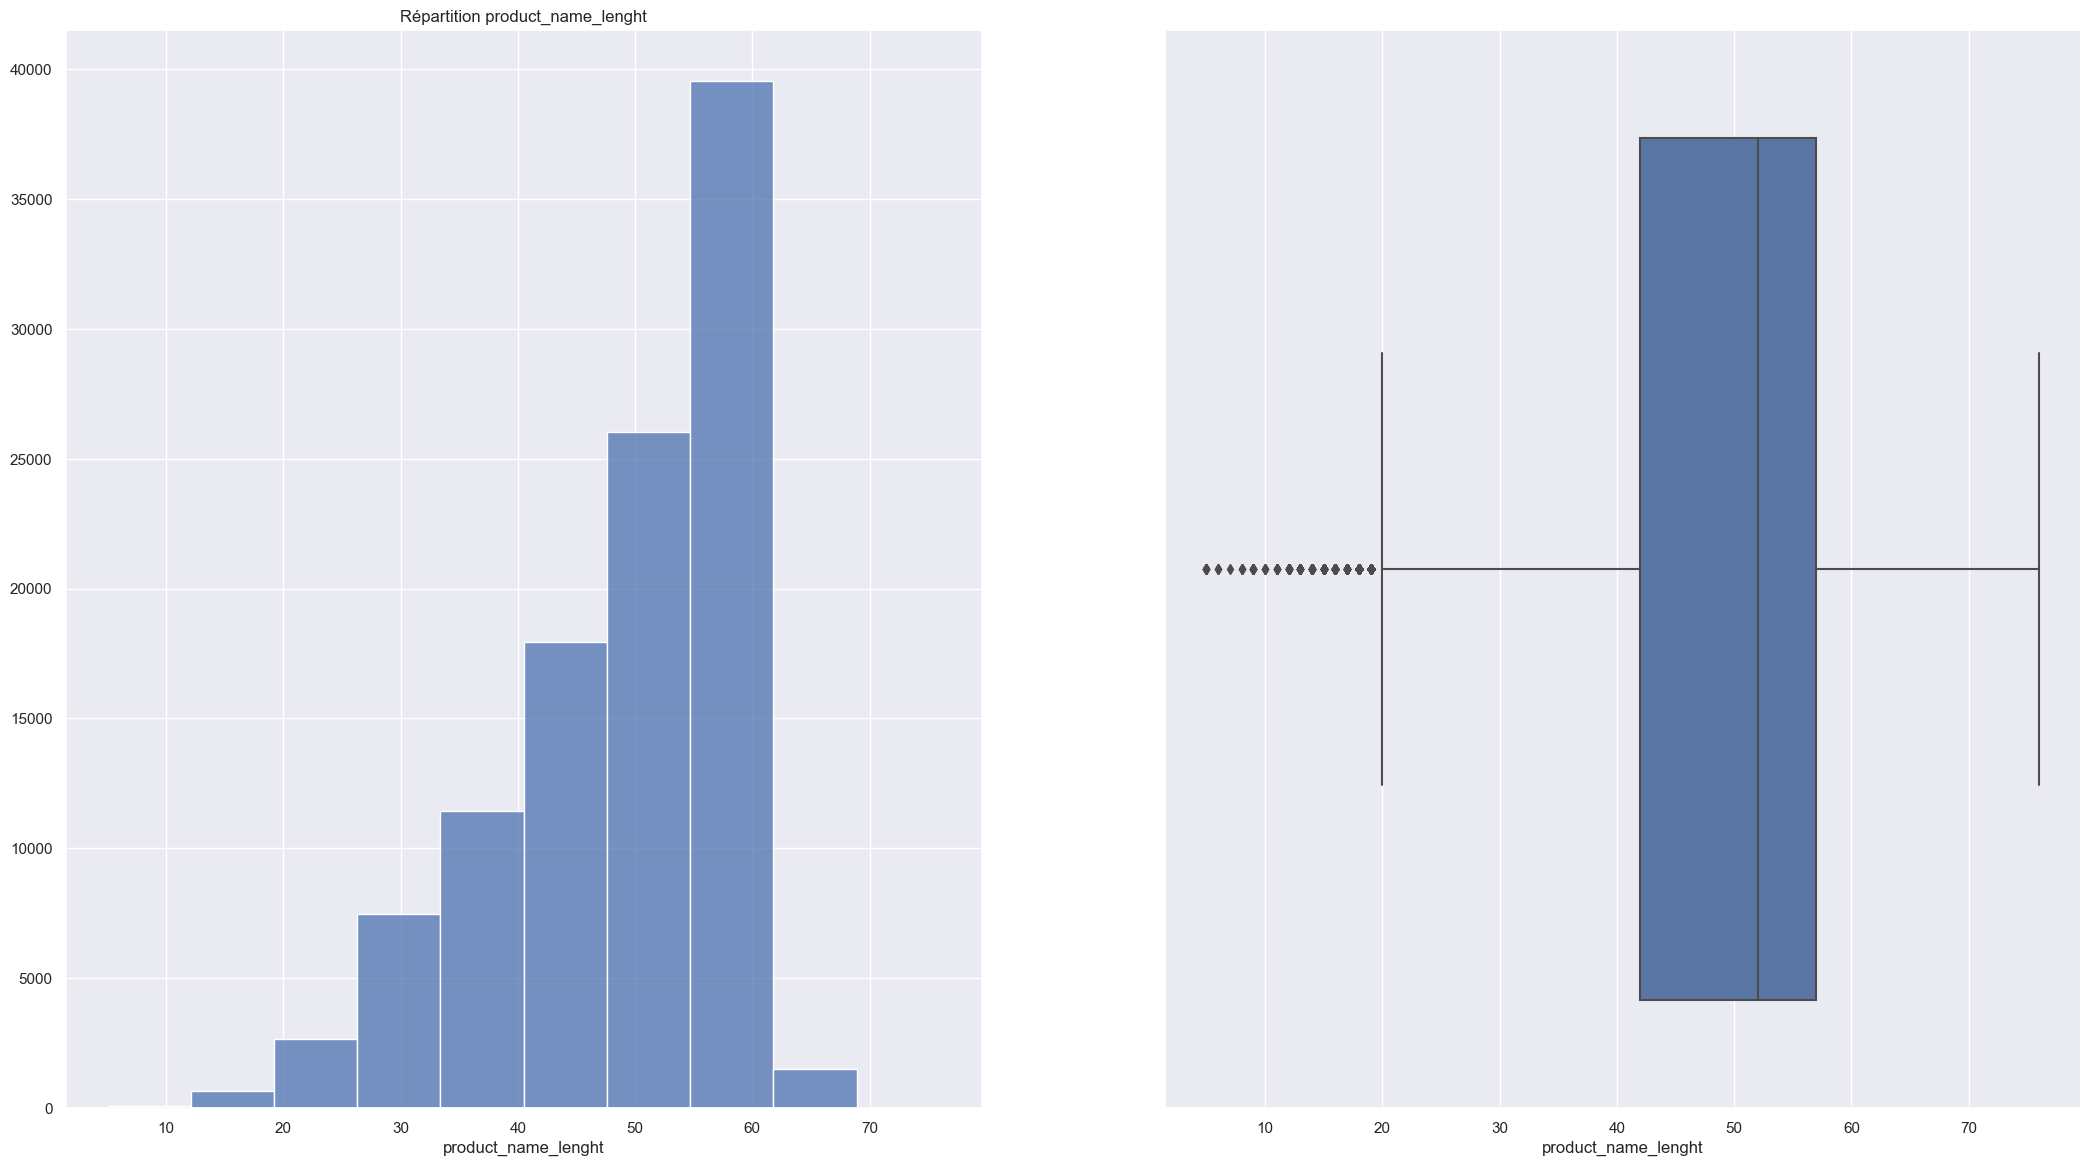

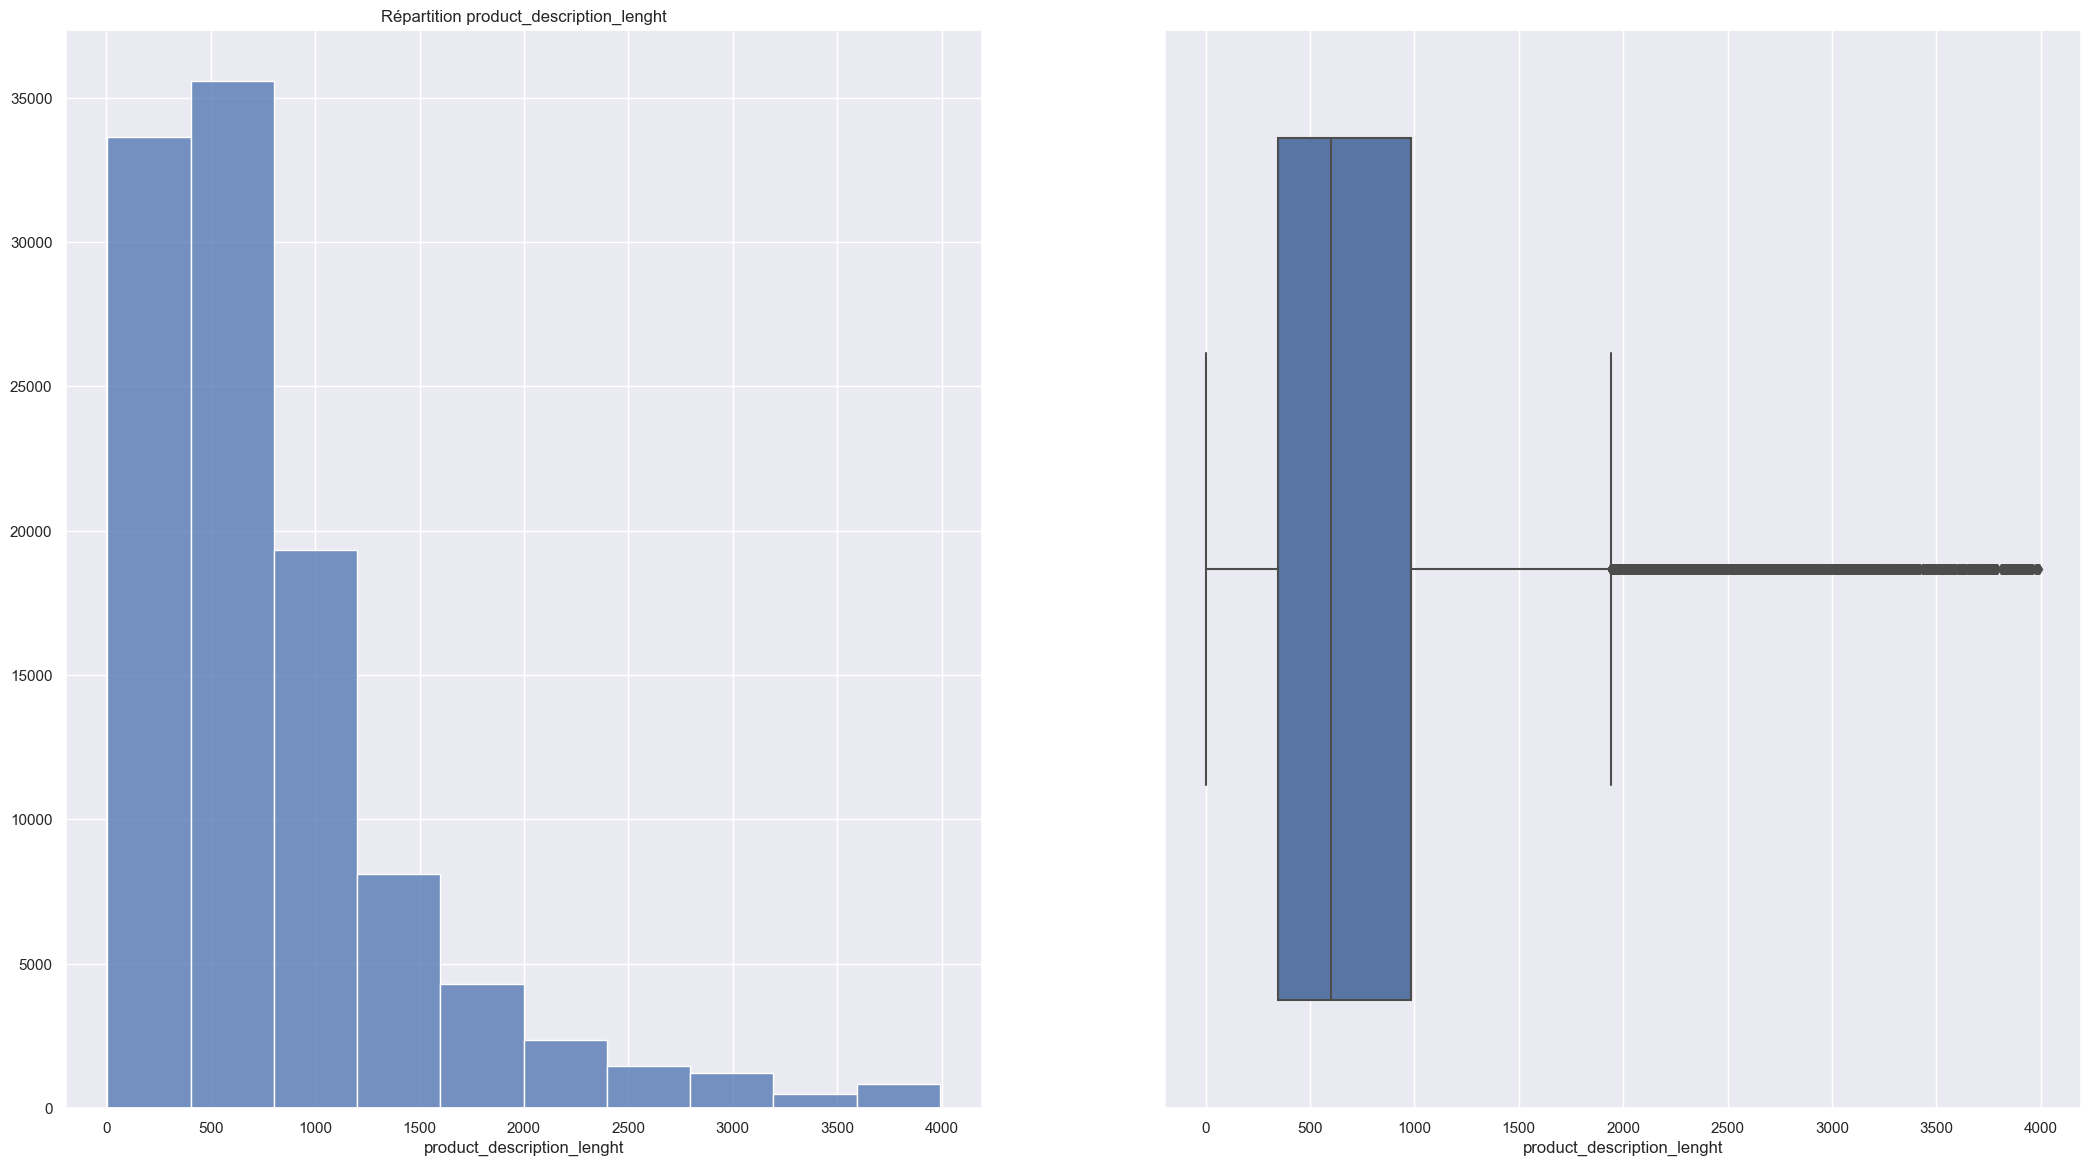

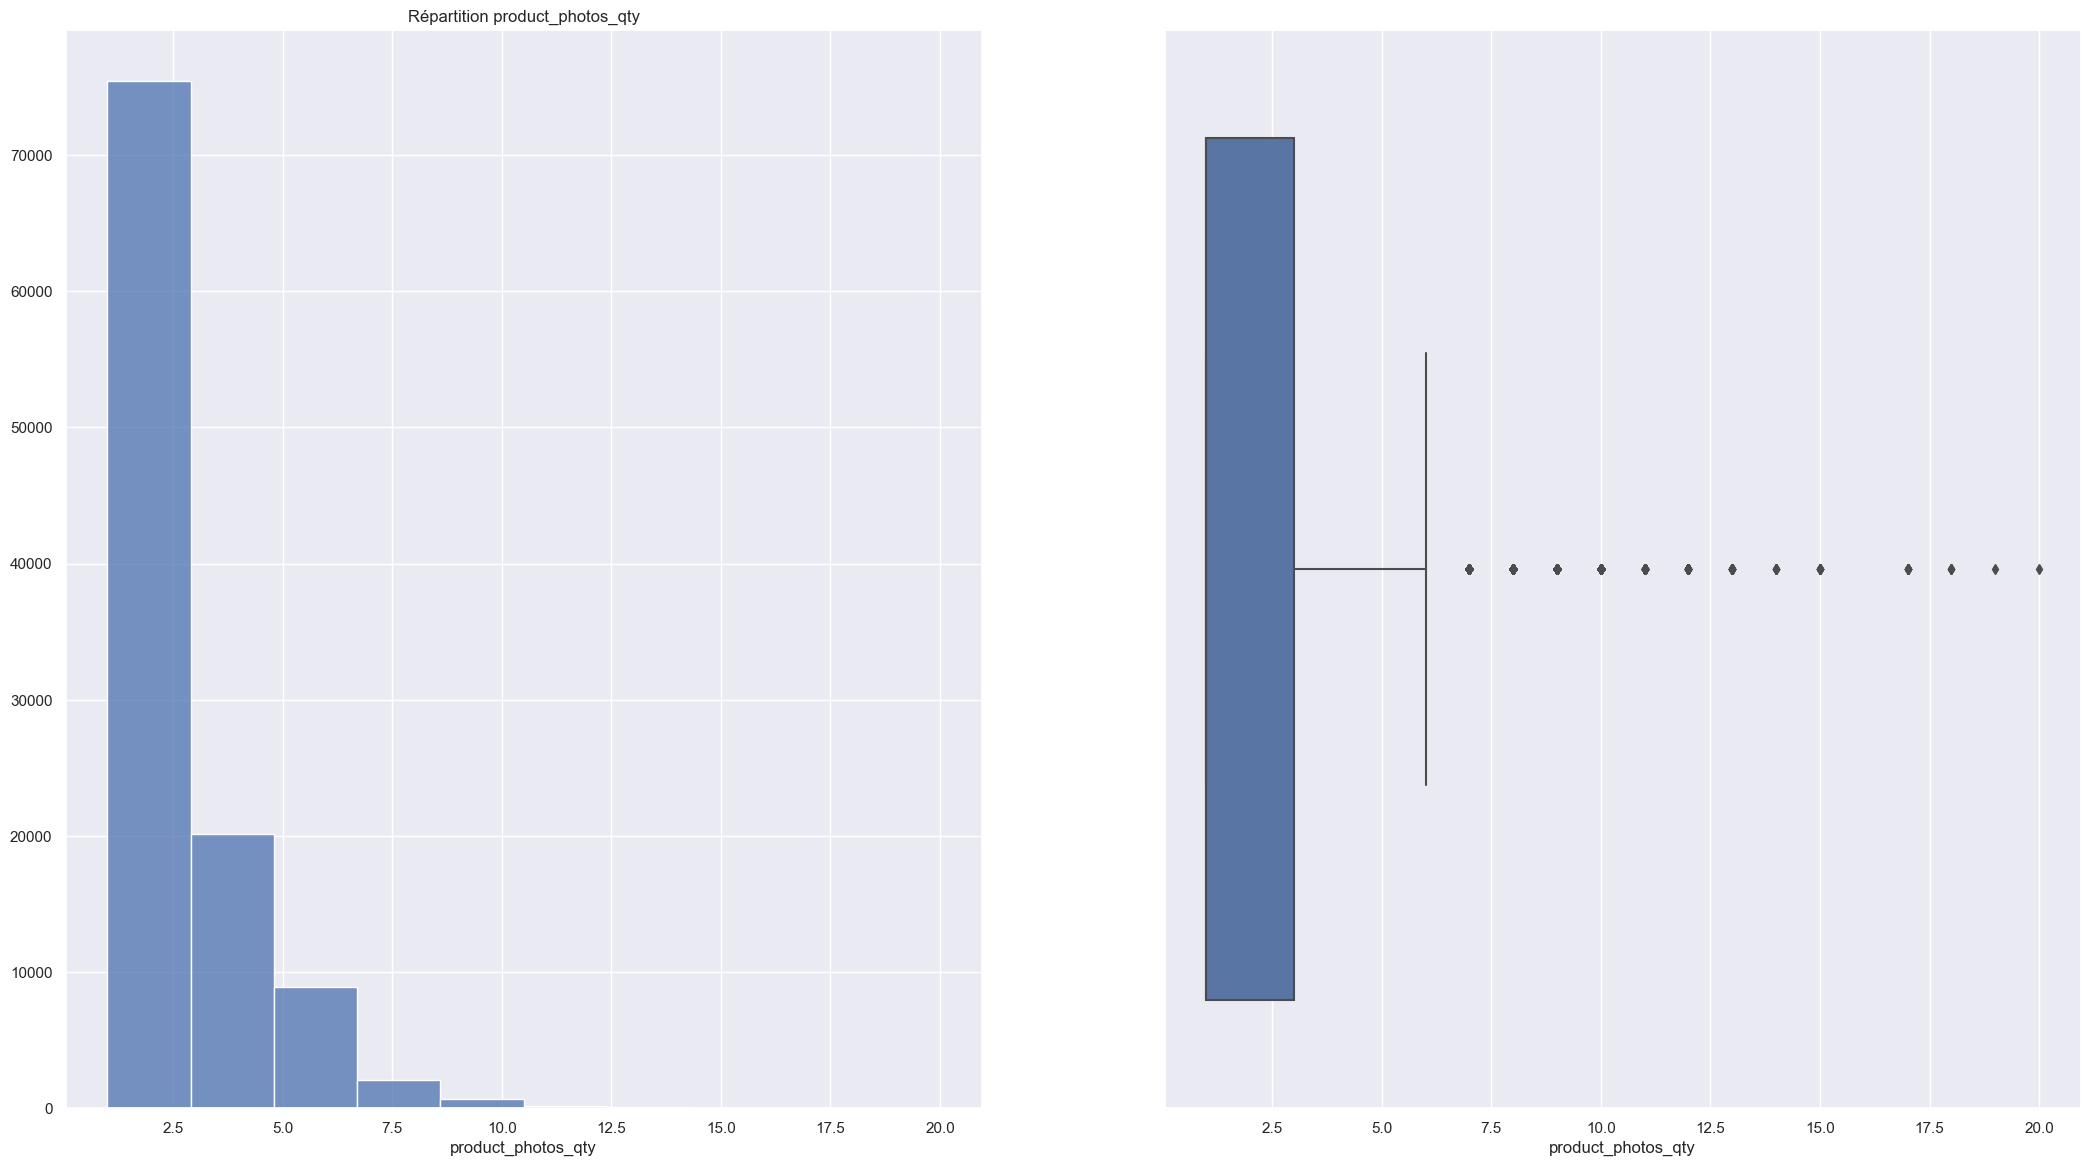

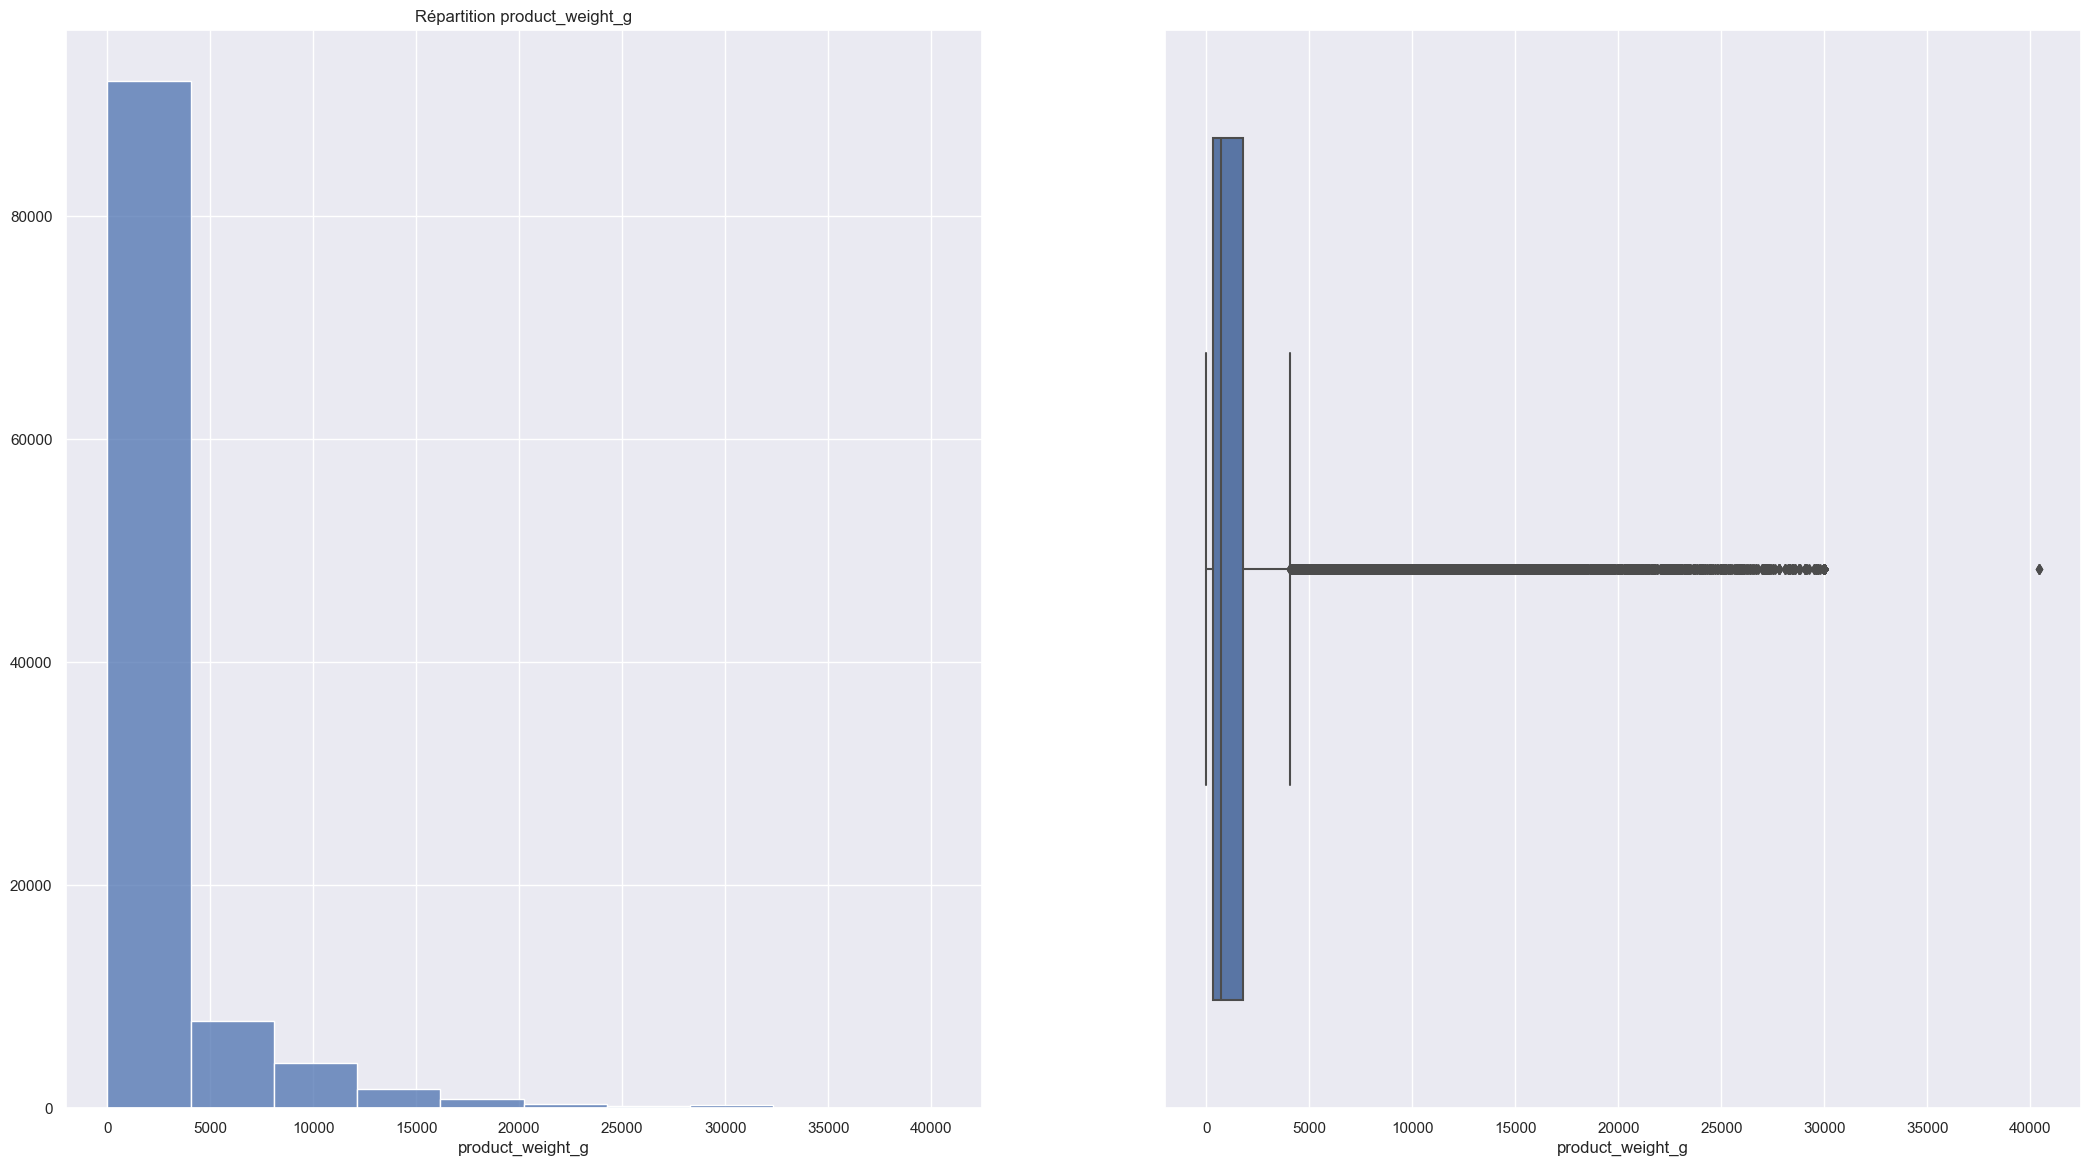

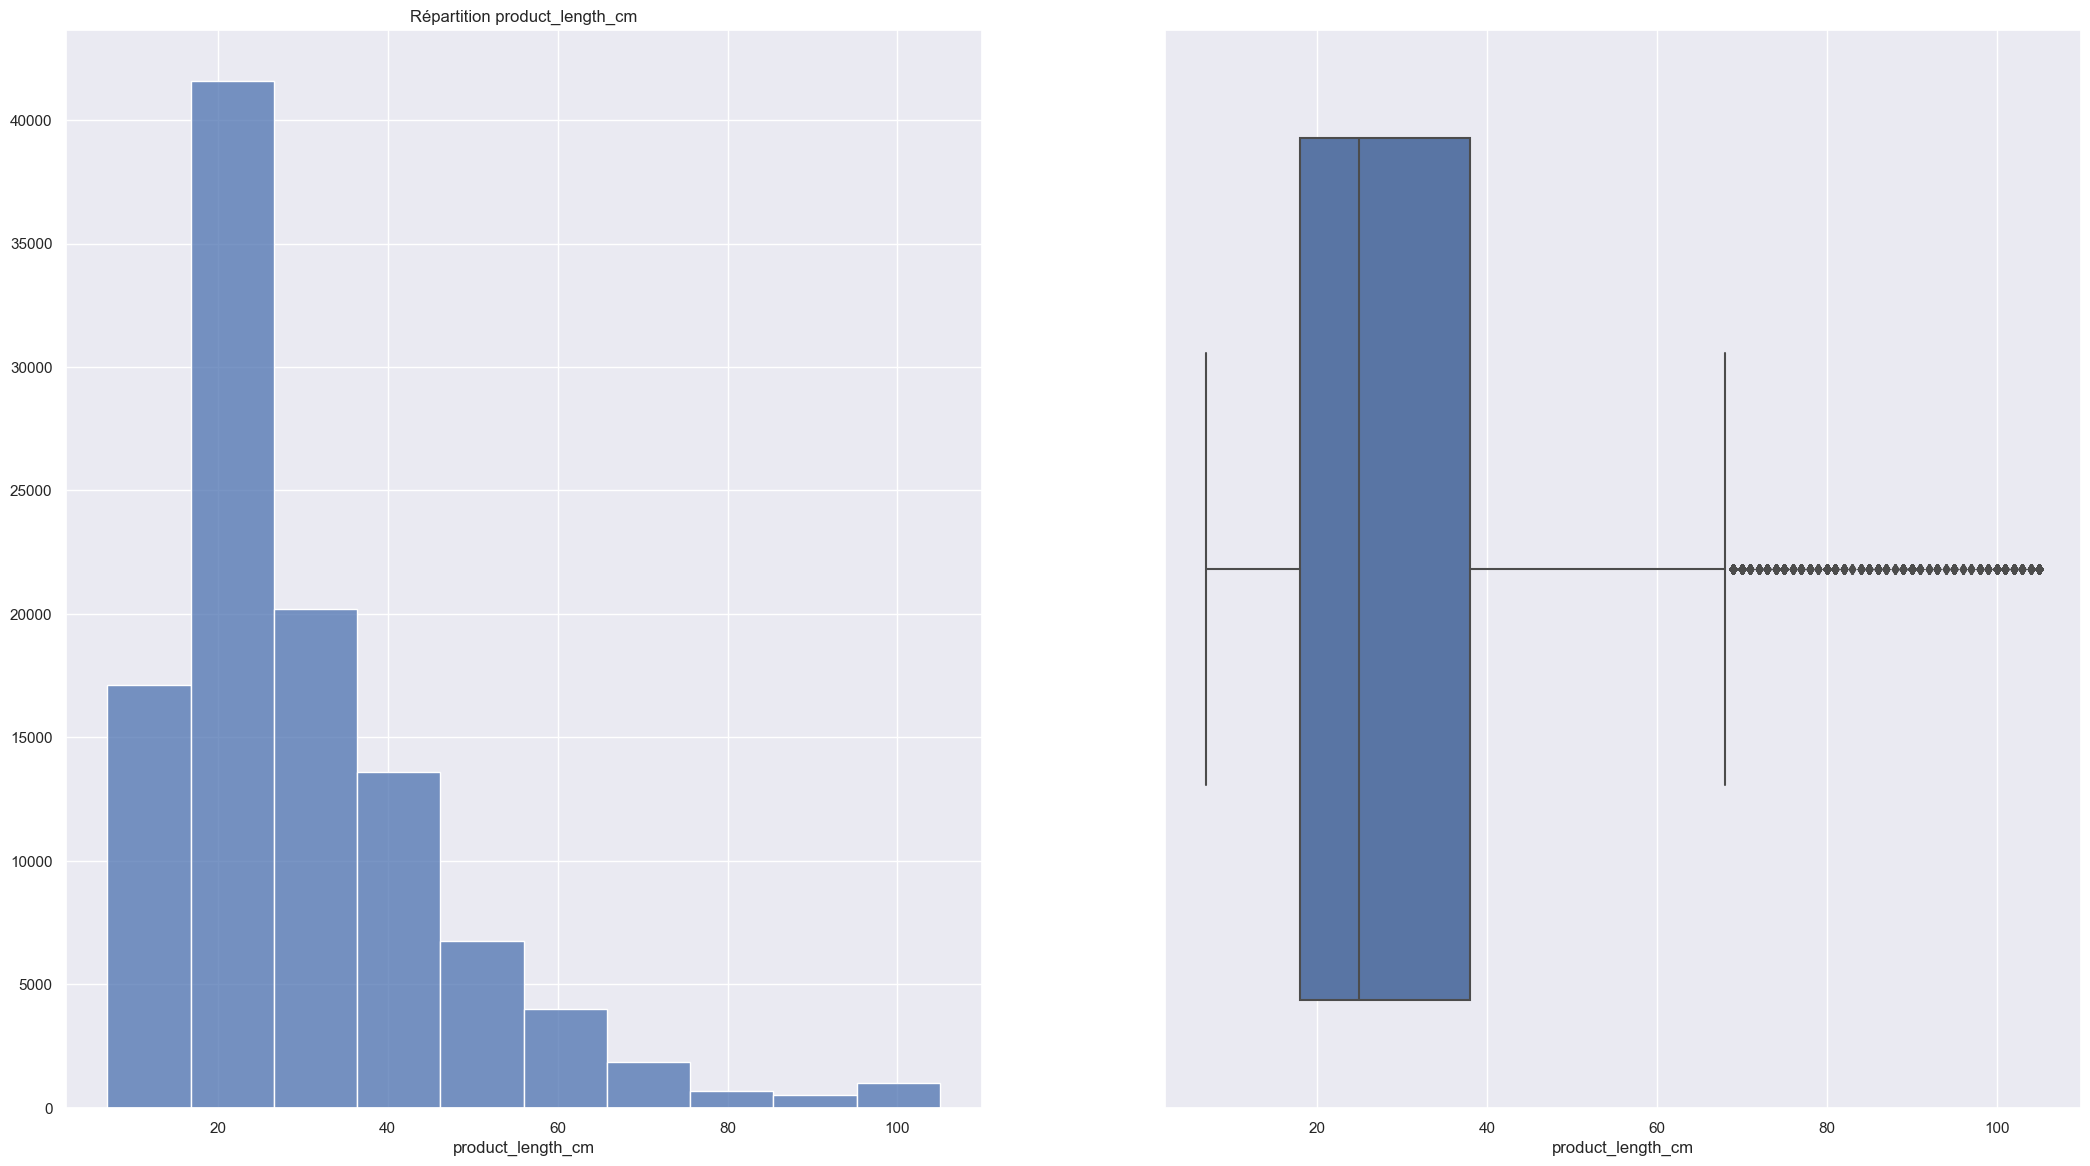

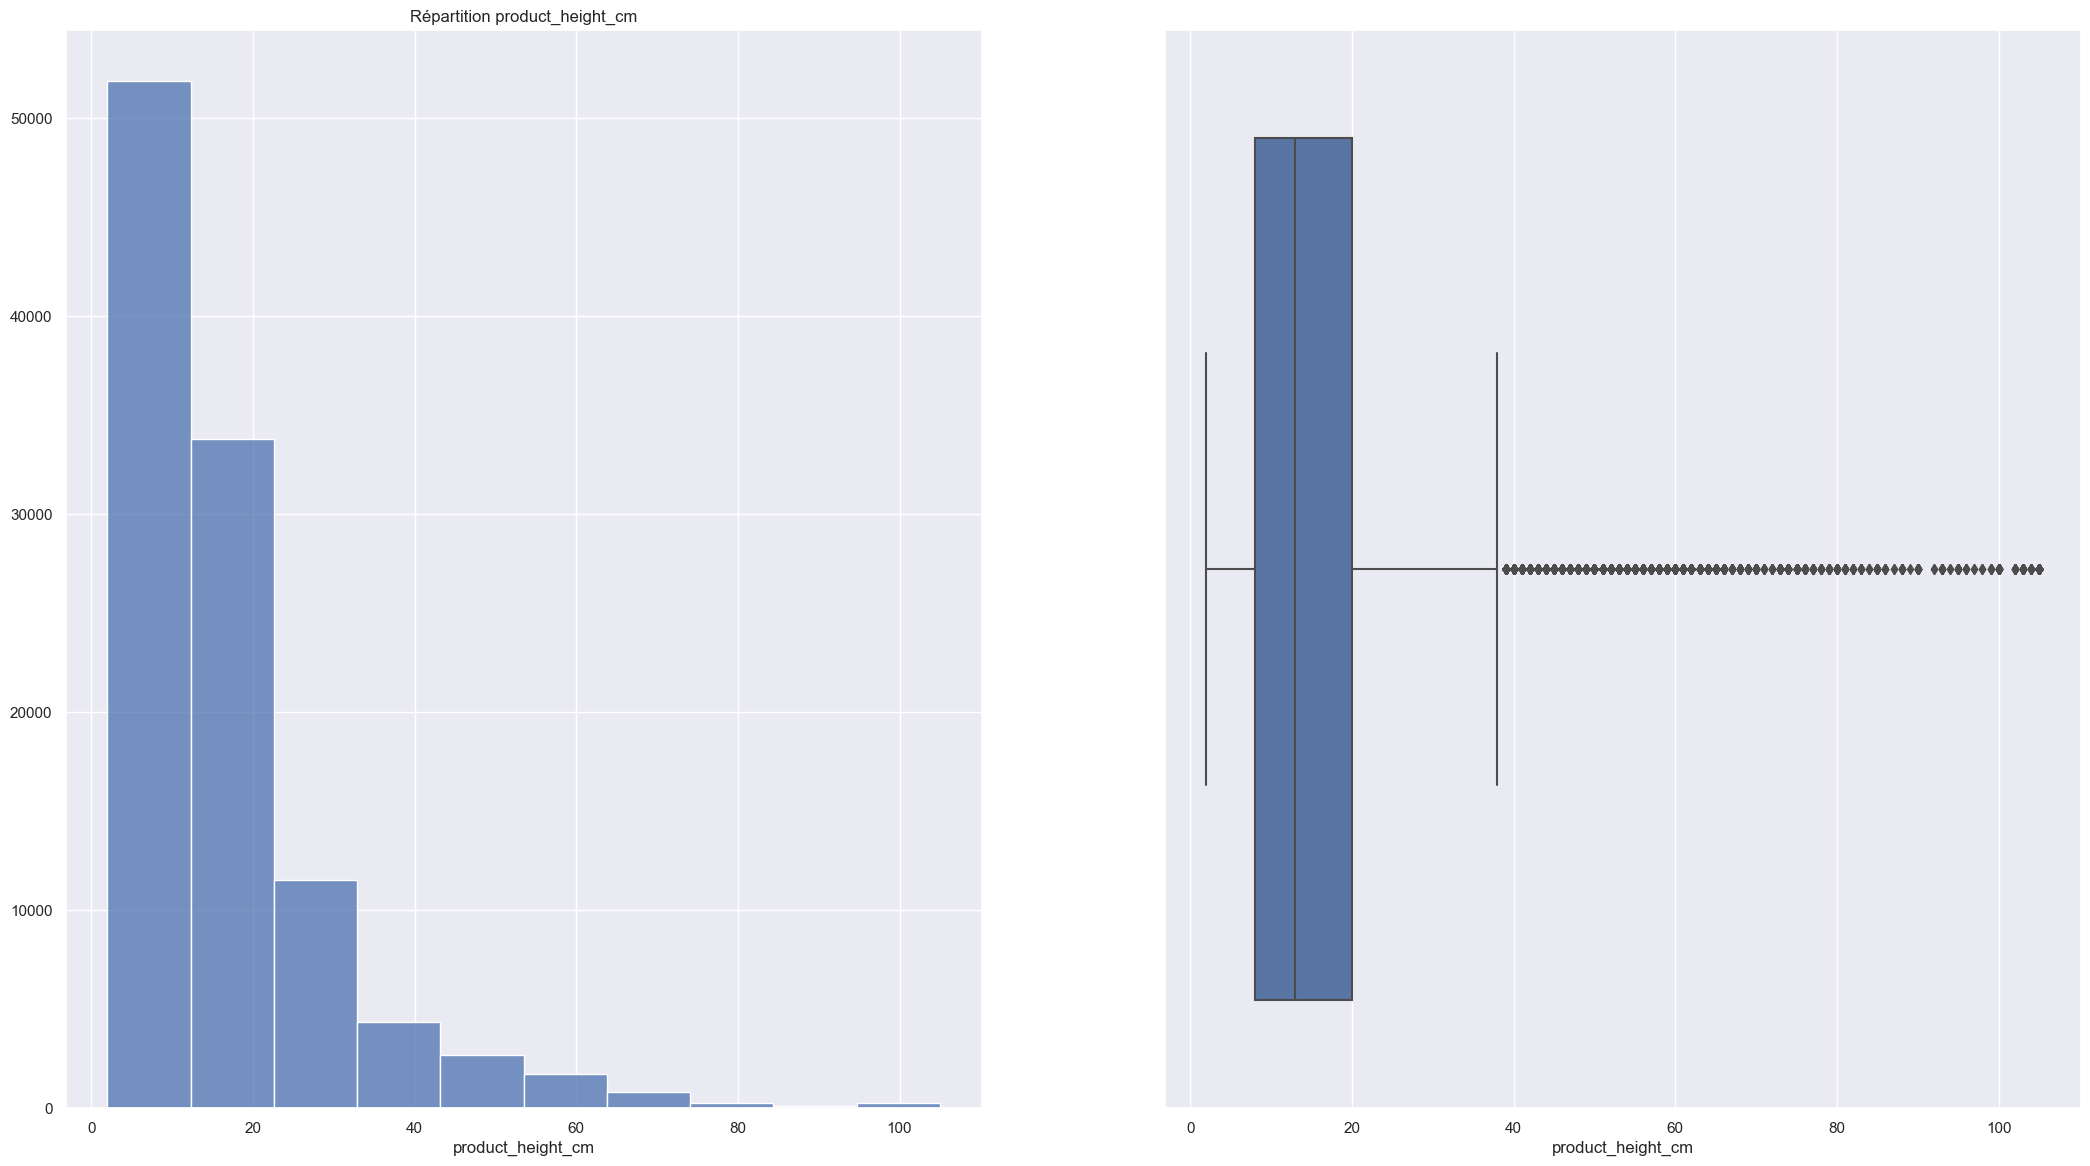

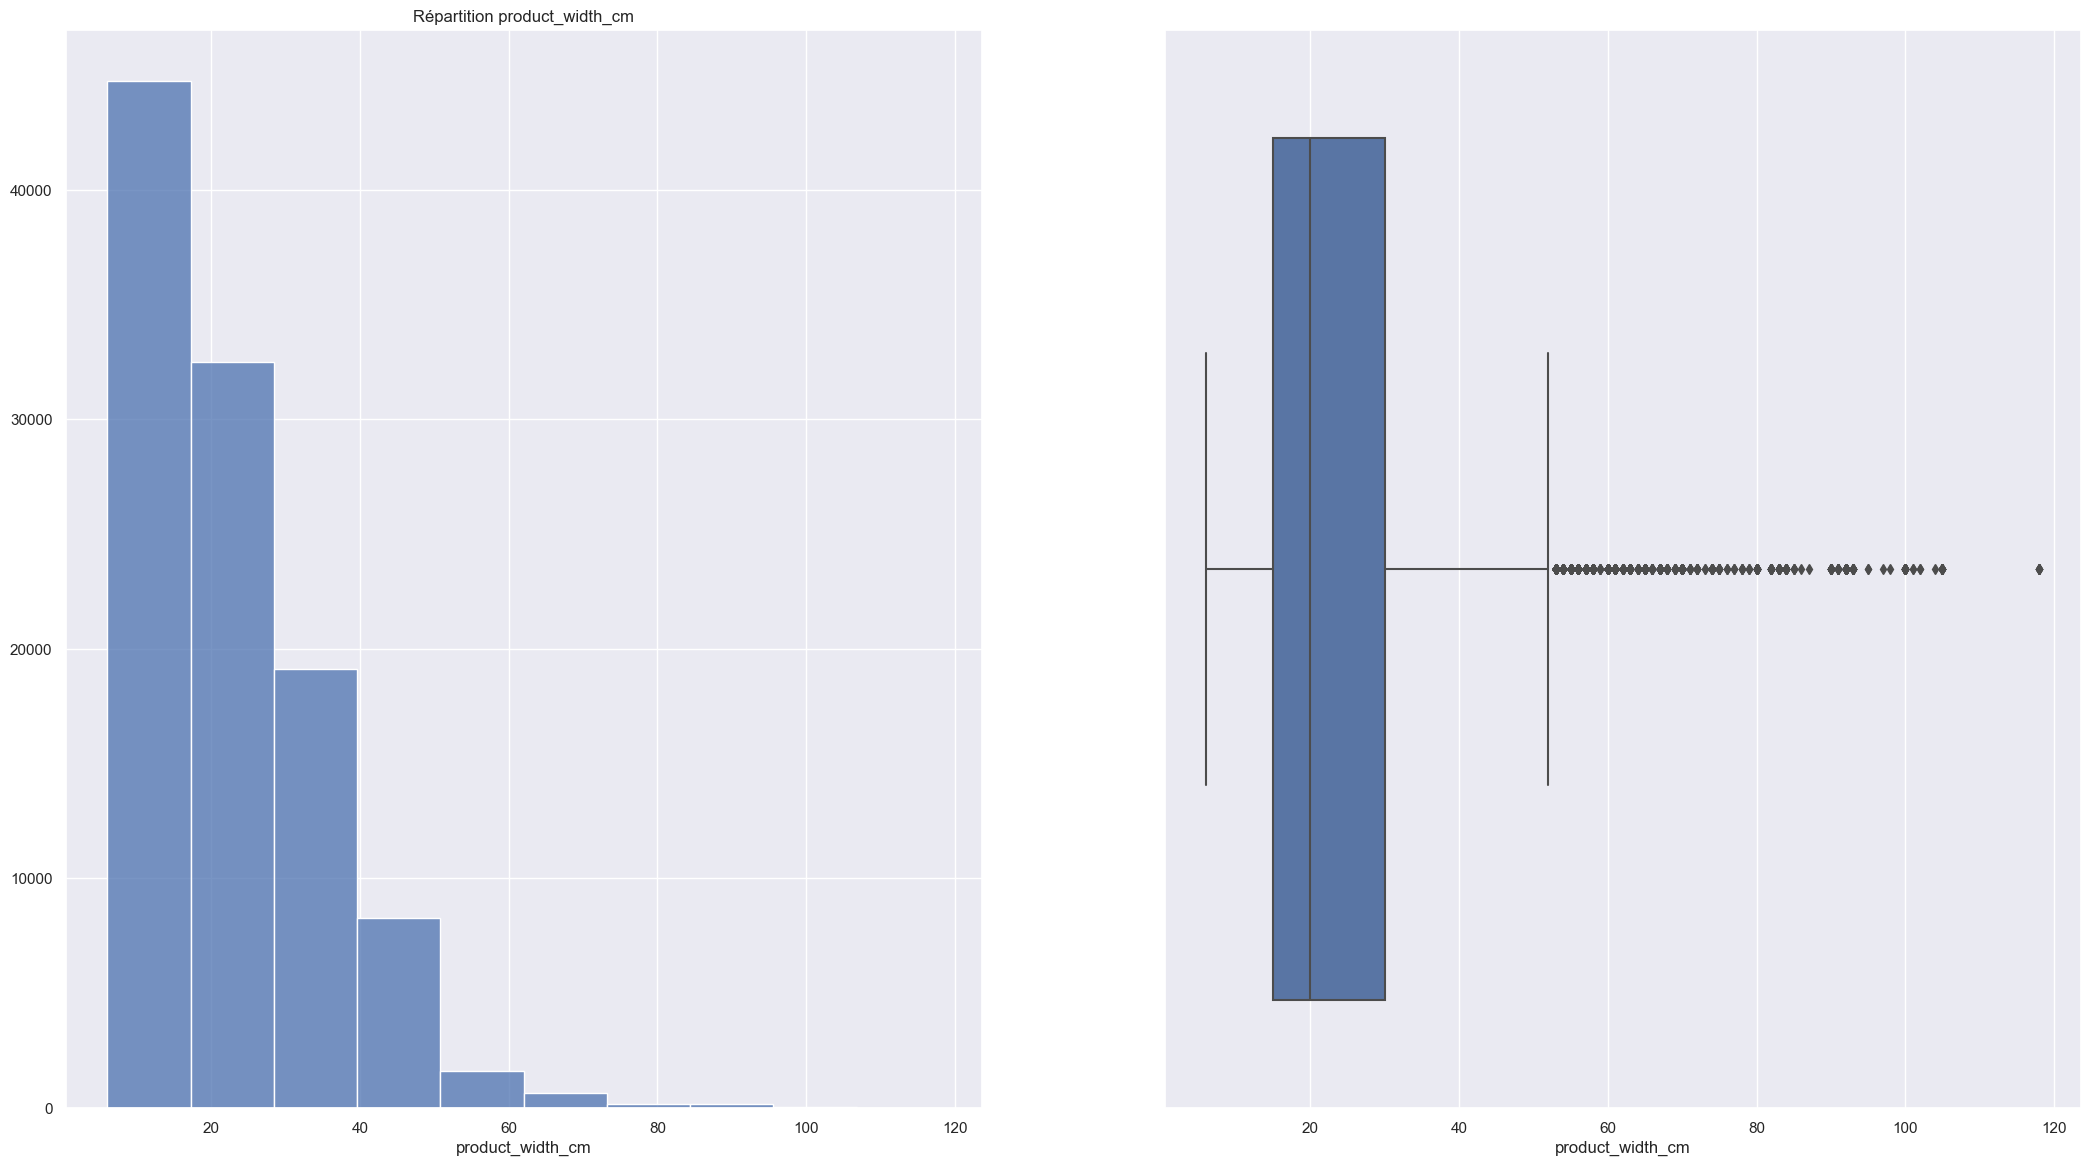

In [217]:
for cat in DF_MAIN.select_dtypes('number').columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 14)) 
    ax1 = sns.histplot(data=DF_MAIN, x=cat, bins=10, ax=ax1)
    ax1.set(title=f'Répartition {cat}')
    ax1.set_ylabel('')
    ax2 = sns.boxplot(x=DF_MAIN[cat], ax=ax2)
    plt.show()  

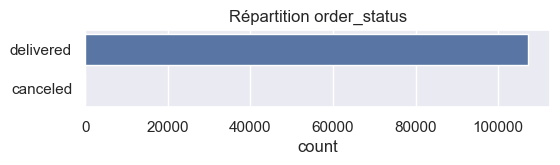

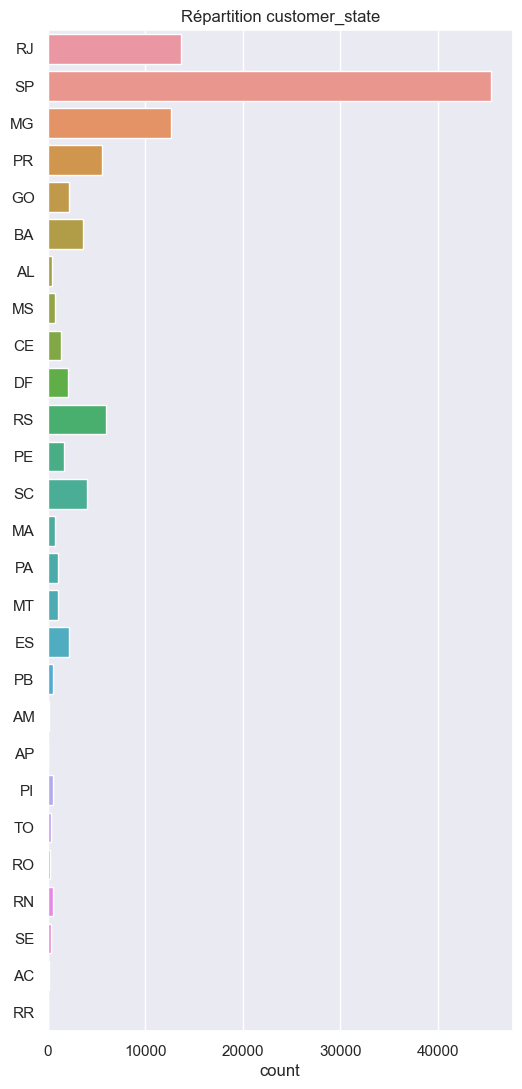

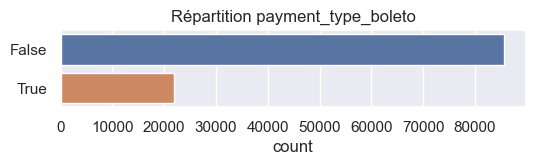

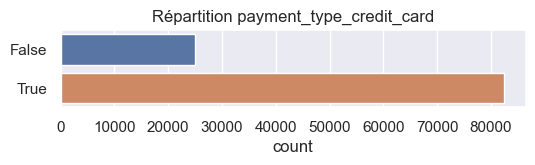

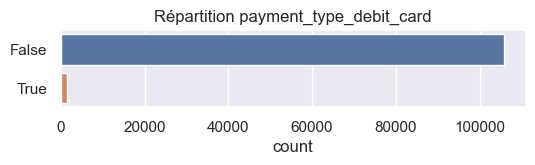

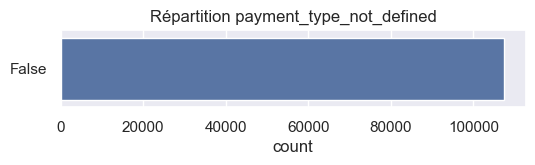

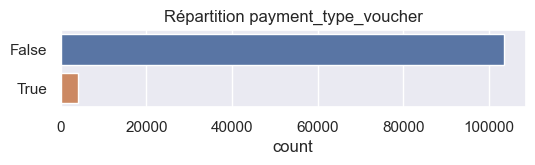

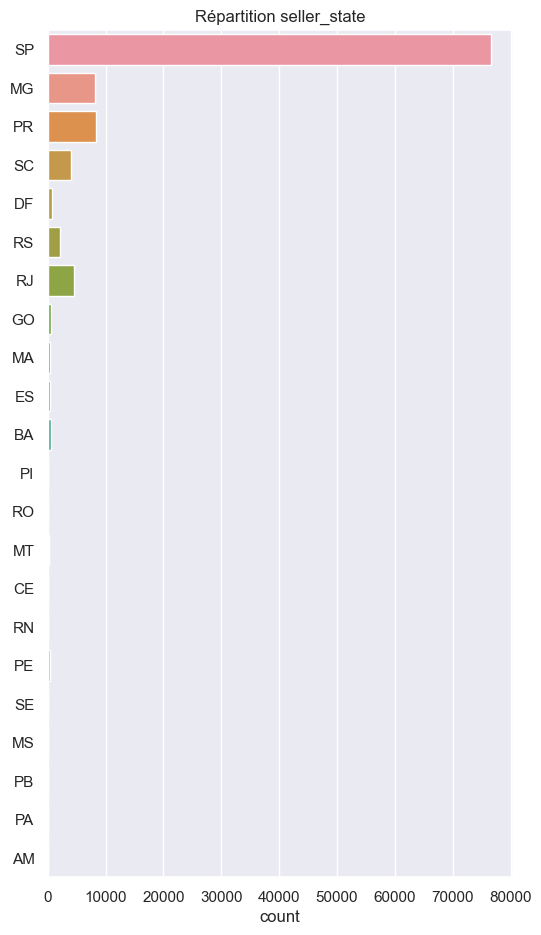

In [215]:
for cat in DF_MAIN.dtypes[DF_MAIN.dtypes == 'object'].index:
    lng = len(DF_MAIN[cat].unique())
    if lng < 30:
        fig = plt.figure(figsize=(6,  max(1, lng//2)))
        ax = sns.countplot(data=DF_MAIN, y=cat)
        ax.set(title=f'Répartition {cat}')
        ax.set_ylabel('')
        plt.show()

In [34]:
label_encoders = {}
for cat in DF_MAIN.dtypes[DF_MAIN.dtypes == 'object'].index:
    label_encoders[cat] = preprocessing.LabelEncoder()
    DF_MAIN[cat] = label_encoders[cat].fit_transform(DF_MAIN[cat])
    
DF_MAIN.dtypes

order_item_id                             int64
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
order_status                              int32
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_zip_code_prefix                  int64
customer_city                             int32
customer_state                            int32
customer_geolocation_lat                float64
customer_geolocation_lng                float64
payment_sequential                      float64
payment_installments                    float64
payment_value                           float64
payment_type_boleto                     float64
payment_type_credit_card                float64
payment_type_debit_card                 